# Comparative Analysis of MAC and LSGA Approaches


> Gianmaria Pizzo - 872966@stud.unive.it

This notebook is part of the First Assignment Submission for the course [Foundations of Artificial Intelligence](https://www.unive.it/data/insegnamento/513734) taught by Professor [Andrea Torsello](https://www.unive.it/data/persone/5590629) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Dataset Overview
* Analysis of CSP Results
* Analysis of LSGA Results
* Comparative Analysis of CSP approach and LSGA approach

---

### Before running this notebook

To avoid issues, before running the following notebook it is best to
* Clean previous cell outputs
* Restart the kernel

## Environment, Imports and Global Variables

In [1]:
# Interactive
# %matplotlib notebook
# Static
%matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore')

## Workspace Setup and Data Loading

In [2]:
# Working folder, where this file is at
WORKING_DIR = os.getcwd()

# Find the right directory
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(WORKING_DIR)), 'data')

# Find dataset
DF_DIR = os.path.join(DATA_DIR, 'raw', 'sudoku_cluewise.csv')
# Find CSP results
CSP_DIR = os.path.join(DATA_DIR, 'benchmark', 'csp_benchmark.csv')
# Find LSGA results
LSGA_DIR = os.path.join(DATA_DIR, 'benchmark', 'lsga_benchmark.csv')

DF_DIR, CSP_DIR, LSGA_DIR

('C:\\Users\\PayThePizzo\\Projects\\SudokuSolver\\data\\raw\\sudoku_cluewise.csv',
 'C:\\Users\\PayThePizzo\\Projects\\SudokuSolver\\data\\benchmark\\csp_benchmark.csv',
 'C:\\Users\\PayThePizzo\\Projects\\SudokuSolver\\data\\benchmark\\lsga_benchmark.csv')

In [3]:
# Import the Dataset
df = pd.read_csv(DF_DIR)

# Import the results for CSP
csp_df = pd.read_csv(CSP_DIR)

# Import the results for LSGA
LSGA_df = pd.read_csv(LSGA_DIR)

## Utility Functions

### Sudoku Utilities

In [4]:
# Utility function for Sudoku
def string_to_sudoku_board(puzzle: str, empty_cell: str = '0', to_np_array: bool = False):
    """Convert a string into a 2D Sudoku board and return it.

    This function gathers the string and verifies its validity
    by checking:
        - The puzzle and the empty cell must be strings.
        - The empty
    if the empty
    cell symbol is coherent with the content of the string. Then
    it creates a 2D array of integers, substituting the empty cell
    symbol with a `0`.
    The returned array-like structure can be
    returned as `np.array`.

    Args:
        puzzle (str): A string of length 81, containing
            digits 1-9 and one empty cell symbol.
        empty_cell (str): A string representing the empty
            celll symbol.

    Raises:
        TypeError: When `puzzle` or `empty_cell` are not
            strings
        ValueError: When `puzzle` length is not exactly 81,
            or when the unique digits are not exactly 1-9 plus
            the empty cell symbol (hence 10).

    Returns:
        list[list[int]] or np.array: An array-like 2D 9x9 list of integers
            representing the sudoku board puzzle.
    """
    # Check type
    if not isinstance(puzzle, str) or not isinstance(empty_cell, str):
        raise TypeError(
            'The arguments puzzle and empty_cell must be strings.'
        )

    # Check length
    if len(puzzle) != 81 or len(empty_cell) != 1:
        raise ValueError(
            'The argument puzzle must be exactly 81 digits long,\n' +
            'while empty_cell must be a string of ' +
            'exactly 1 digit.'
        )

    # Find the unique values in the string
    unique_values = set(puzzle)
    # Record the valid values for sudoku
    valid_values = set('123456789')
    valid_values.add(empty_cell)

    # Check if unique set is subset of valid set and length is respected
    if len(unique_values) > 10 or not (unique_values <= valid_values):
        raise ValueError(
            'The puzzle string must contain exactly 10 unique values:' +
            'digits 1-9 and one empty cell symbol. '
        )

    # Construct Board
    board = []

    for idx_r in range(9):
        row = []
        for idx_c in range(9):
            # Check value
            cell = puzzle[idx_r * 9 + idx_c]

            # Append correct value to row
            if cell == empty_cell:
                row.append(0)
            else:
                row.append(int(cell))

        board.append(row)

    # Convert to np.array
    if to_np_array:
        board = np.array(board)

    return board


def print_sudoku_board(puzzle) -> None:
    """Print the Sudoku board in a formatted way.

    Args:
        puzzle (np.ndarray): A 9x9 matrix representing the Sudoku board.

    Returns:
        None
    """
    for i in range(9):
        # Print horizontal lines for sub-grids
        if i % 3 == 0 and i != 0:
            print('-' * 21)
        # Print each row
        row = (
            ' | '.join(
                ' '.join(
                    str(num)
                    if num != 0 else '.'
                    for num in puzzle[i, j: j+3]
                ) for j in range(0, 9, 3)
            )
        )
        print(row)

    pass


def is_valid_solution(board) -> bool:
    """Check if a given 9x9 numpy array represents a valid Sudoku solution.

    Args:
        board (np.array): A 9x9 grid of integers.

    Returns:
        bool: True if the board is a valid Sudoku solution, False otherwise.
    """
    # Check if the shape is 9x9
    if board.shape != (9, 9):
        return False

    # Check each row, column, and 3x3 subgrid for validity
    for i in range(9):
        # Check if each row and column contain numbers 1 to 9 without repetition
        if not (np.array_equal(np.sort(board[i, :]), np.arange(1, 10)) and
                np.array_equal(np.sort(board[:, i]), np.arange(1, 10))):
            return False

        # Check the 3x3 subgrid
        row_offset = (i // 3) * 3
        col_offset = (i % 3) * 3
        subgrid = board[row_offset:row_offset+3, col_offset:col_offset+3].flatten()
        if not np.array_equal(np.sort(subgrid), np.arange(1, 10)):
            return False

    return True


### Pandas Utilities

In [5]:
# Utility functions for rows and columns

def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically and leaves last_label for last

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
        col = dataset.pop(last_label)
        dataset.insert(dataset.shape[1], last_label, col)
    return dataset

def get_cols(dataset, col_substring):
    """
    Returns the dataset having only the columns matching the substring, that are in the dataset
    
    :param dataset: pandas.DataFrame
    :param col_substring: a list of str
    :returns: a list of columns present inside dataset, matching the substring
    """
    if col_substring is not None:
        all_columns = list(dataset.columns)
        # Add only if in dataset
        col_lst = [i for i in all_columns if col_substring in i]
        return col_lst
    return None

def drop_if_exists(dataset, to_drop: list, inplace=True):
    """
    Drops rows from list to_drop if they are found inside the dataset
    
    :param dataset: a pd.DataFrame
    :param to_drop: a list of str containing existing column labels in the dataset to drop
    :param inplace: a boolean representing whether to drop column in place, if True it returns None
    :returns: None if inplace is True, else a pd.DataFrame without the columns in to_drop (if present in dataset)
    """
    all_columns = list(dataset.columns)
    # Include only columns that are existing 
    cols_to_drop = [i for i in all_columns if i in to_drop]
    if cols_to_drop is not None:
        if inplace:
            return dataset.drop(columns = cols_to_drop, inplace=inplace)
        return dataset.drop(columns = cols_to_drop, inplace=inplace)
    pass

def drop_rows_cond(dataset, condition, inplace = True):
    """
    Drops rows on boolean condition and resets index
    
    :param dataset: pandas.DataFrame
    :param condition: boolean condition between braces, regarding this dataset (such as: (dataset['Label']!=0) )
    :param inplace: boolean
    :returns: pandas.DataFrame if inplace = False, else None
    """
    rows_to_drop = dataset[condition].index.tolist()
    if inplace:
        dataset.drop(rows_to_drop, inplace=inplace)
        dataset.reset_index(drop=True, inplace=inplace)
    else:
        return dataset.drop(rows_to_drop)

### Plot Utilities

In [6]:
# Plot functions for numeric features

def plot_frequency_distr_numeric(dataset, exclude = None, include_kde=False, plot_cols=2, notebook_fig_size=None, adjust=None):
    """
    Plots the frequency distributions of its numeric features through histograms from seaborn
    
    :param exclude: a string list representing the columns to exclude
    :param include_kde: boolean representing whether to include kde
    :param dataset: pandas dataframe
    :param plot_cols: count of plots per column
    :param notebook_fig_size: dictionary of integers including keys 'width', 'height' which represent the measures in inches for notebook display purposes
    :param adjust: dictionary of float including keys 'left', 'right', 'top', 'bottom', 'wspace', 'hspace' which are used to space the different plots between them
    """
    # Numeric dataframe
    num_df = dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    
    if exclude is not None:
        num_df = num_df.drop(exclude, axis=1)
    
    # Set subplot shape
    fig, axes = plt.subplots(nrows = int(np.ceil(num_df.shape[1]/plot_cols)), ncols = plot_cols, figsize=(9,2))
    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()
    
    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(10, 40)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))
    
    # Plot distribution for each feature
    for ax, col in zip(axes, num_df.columns):
        sns.histplot(data=num_df, y=col, ax = ax, color='cornflowerblue', kde=include_kde, stat='count')
        ax.set_title(col.replace("_", " ")+'\'s Distribution', fontweight='bold')
        ax.set_ylabel('Values')
        ax.set_xlabel('Count')
        
    # Adjust spacing between plots
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.05, wspace=0.4, hspace=0.9)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass

# Util function for pretty printing
def print_num_col_skewness(dataset, exclude = None):
    """
    Prints the skewness of the numeric columns in the dataset
    
    : param dataset: pandas.DataFrame
    : param exclude: list of str representing column labels to exclude
    : returns: None
    """
    for x in dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']):
        if exclude is not None and x in exclude:
            continue
        else:
            print("Skewness of " + x + ": \n" + str(scipy.stats.skew(df[""+x])) + "\n")
    pass

In [7]:
# Utility function for categorical features

from itertools import zip_longest

# We use a decoded version of the dataset to display the labels better
def decode_byte_str(dataset):
    """
    Decodes the dataset's object feature values in place and substitutes the byte-code string formatting b''
    
    : param dataset: a pandas.DataFrame
    : returns: None
    """
    categorical = dataset.select_dtypes(object)
    categorical = categorical.stack().str.decode('utf-8').unstack()
    for col in categorical:
        dataset[col] = categorical[[col]].apply(lambda x: x.str.replace("b'", "").str.replace("'", ""))
    pass

def barplot_categ(dataset):
    """
    Produces a barplot for a dataset, including only the object types
    
    : param dataset: a pandas.DatFrame
    : returns: None
    """
    # Categorical Features Only 
    categorical_data = dataset.select_dtypes(object)
    # Rows
    n = categorical_data.shape[1]
    # Params for subplots
    nrows, ncols = (int(np.ceil(n / 2))+1, 2)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9.9, 60))
    
    for feature_name, ax in zip_longest(categorical_data, axs.ravel()):
        if feature_name is None:
            # Avoid showing axis
            ax.axis("off")
            continue

        ax = categorical_data[feature_name].value_counts().plot.barh(ax=ax, color='cornflowerblue')
        ax.set_title(feature_name + '\'s Frequency', fontweight='bold')
        ax.set_xlabel('Count', fontsize = 8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        plt.setp(ax.get_yticklabels(), rotation=40)

    plt.subplots_adjust(left=0.2,
                    bottom=0.02,
                    right=0.9,
                    top=0.98,
                    wspace=0.9,
                    hspace=0.9)
    pass


def boxplot_categ(dataset, target):
    """
    Produces a target related boxplot for a dataset, including only the object types
    
    : param dataset: a pandas.DatFrame
    : param target: a string label for a column
    : returns: None
    """
    # Categorical Features Only 
    categorical_data = dataset.select_dtypes(object)
    # Rows
    n = categorical_data.shape[1]
    # Params for subplots
    nrows, ncols = (n, 1)
    
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, n*7))
    
    for feature_name, ax in zip_longest(categorical_data, axs.ravel()):
        if feature_name is None:
            # Avoid showing axis
            ax.axis("off")
            continue   
        ax = dataset[[target, feature_name]].boxplot(ax=ax, rot = 45,
                                                     column=target,
                                                     by=feature_name)
        ax.set_title(feature_name + ' Boxplot', fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        plt.setp(ax.get_yticklabels(), rotation=40)

    plt.subplots_adjust(left=0.2,
                    bottom=0.03,
                    right=0.9,
                    top=0.96,
                    wspace=0.7,
                    hspace=0.7)
    pass

In [8]:
# Utility distribution and probability functions to plot numerical features

from scipy import stats
from scipy.stats import probplot

# Module for numerical variables
def get_df_wo_outliers(dataset: pd.core.frame.DataFrame , label: str, threshold=(0.05,99.95)):
    """
    Returns a copy of the given dataset, after removal of the extreme values specified for a numeric label
    
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param threshold: tuple of 2 float representing the extremes to drop
    : returns: pd.core.frame.DataFrame
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(threshold) != tuple or len(threshold) != 2) or (type(threshold[0]) != float or type(threshold[1]) != float):
        raise Exception("Threshold must be an float tuple of length 2")
    if threshold[0] > threshold[1]:
        raise Exception("The element in position 0 should smaller than the one in position 1")
    if threshold[0] < 0.0 or threshold[1] > 100.0:
        raise Exception("Threshold out of range")
    
    stats_dict = dataset[label].describe().to_dict()
    uppr = np.percentile(dataset[label].values, float(threshold[1]))
    lwr = np.percentile(dataset[label].values, float(threshold[0]))
    return dataset.loc[(dataset[label] >= lwr) & (dataset[label] < uppr)]


def numeric_distr_plot(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots distribution of the given dataset's column specified in label
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
                               
    # Normal Distribution fit
    (mu, sigma) = stats.norm.fit(dataset[label])

    # Feature Distribution Plot
    plt.figure(figsize=shape)
    sns.distplot(dataset[label], hist=True, kde=True, fit=stats.norm, color='cornflowerblue')
    
    # Figure labels
    plt.title(label.replace("_", " ") + '\'s Distribution vs Normal Distribution', fontsize=14)
    plt.xlabel(label.replace("_", " "))
    plt.ylabel('Frequency in %')
    plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='upper right')
    plt.show()
    pass

def probability_plot(dataset: pd.core.frame.DataFrame , label: str):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    fig = plt.figure()
    res = stats.probplot(dataset[label], plot=plt)
    plt.show()
    pass

def scatterplot_distr(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
        
    plt.figure(figsize=shape)
    plt.scatter(range(dataset[label].shape[0]), np.sort(dataset[label].values))
    plt.title(label + '\'s Scatter Plot')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.show()
    pass

### Correlation Utilities

In [9]:
# Utility functions for correlation analysis

def display_corr_matrix(dataset: pd.core.frame.DataFrame, label: str, exclude = None):
    """
    Displays the correlation matrix and returns it
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param exclude: list of str of features to exclude
    : returns: correlation matrix
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    if exclude is not None:
        if type(exclude) == list:
            for i in exclude:
                if type(i)!= str:
                    raise Exception("exclude must be a list of string")
                if i not in dataset.columns:
                    raise Exception(i + " is not a valid column label")
        else:
            raise Exception("exclude must be a list")
            
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))
    
    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix


def top_correlated_features(corr_matrix, label, threshold=0.45):
    """
    Returns a dictionary of the top correlated features with label, inside the dataset, for a certain threshold
    
    """
    
    m = corr_matrix[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict


def display_correlation(sample_dict, exclude=None):
    """
    Prints the correlated features for all the top correlated features with the target
    
    """
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            if exclude is not None and k in exclude:
                continue
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

### Numeric Plot Utilities

In [10]:
# Module for categorical variables
def scatterplot_single(dataset, target, label, hue=None):
    """
    Quick ad hoc function to display a scatterplot
    
    """
    sns.lmplot(data=dataset, x=target, y=label, aspect=1.5, scatter=True, hue=hue)
    pass

def scatterplot_multiple(dataset, target, labels, plot_cols=1, notebook_fig_size=None, adjust=None, hue=None):
    """
    Quick ad hoc function to display multiple scatterplots
    
    """
    
    fig, axes = plt.subplots(nrows = int(np.ceil(len(labels)/plot_cols)), ncols = plot_cols)

    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()

    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(9, 8*plot_cols)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))

    # Plot 
    for ax, col in zip(axes, dataset.loc[:, dataset.columns.isin(labels)].columns):
        sns.regplot(data=dataset, x=target, y=col, fit_reg=True, scatter=True, ax=ax)
        ax.set_title(col + " vs " + target, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel(target)

    # Adjust 
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.2, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.5)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass


def stripplot_single(dataset, target, categ_feat, figsize=None):
    """
     Quick ad hoc function to display stripplot
    
    """
    
    if figsize is None:
        fig, ax = plt.subplots(figsize=(11,7))
    else:
        fig,ax = plt.subplots(figsize=figsize)
    
    sns.stripplot(y=categ_feat, x=target, data =dataset, jitter = True, dodge = True, ax=ax)
    pass

## Dataset overview: 4 Million Sudoku Puzzles

This Dataset was created by [RyanAn](https://www.kaggle.com/informoney) and can be found on [Kaggle](https://www.kaggle.com/datasets/informoney/4-million-sudoku-puzzles-easytohard/code).

The dataset is designed to test the effectiveness of Sudoku-solving algorithms across a spectrum of puzzle difficulties, with puzzles ranging from easy to very challenging levels. Each puzzle's difficulty correlates with the number of clues (pre-filled digits), where more clues indicate an easier puzzle and fewer clues imply a more challenging one.

In this project, we test our algorithms on random samples 5 random samples of 50 sudokus. Each random sample has an increasing difficulty, in particular two of them have a strict range of clues to test the algorithms on very hard problems (less than 25 clues).


### Key Characteristics
- **Difficulty and Clues**: 
    - Each puzzle has between 17 and 80 clues.
    - **Easy puzzles** have up to 80 clues, making them quicker to solve.
    - **Hard puzzles** contain as few as 17 clues, which is the minimum necessary to form a solvable puzzle.
- **Magic Number 17**: 
    - A 17-clue puzzle is the threshold for having a valid and solvable Sudoku puzzle with guaranteed logic-based solutions.

### Dataset Structure
- **Total Puzzles**: 4 million unique puzzles.
- **Puzzle Distribution**: 62,500 puzzles for each clue count from 17 to 80, allowing comprehensive coverage across difficulty levels.
- **Format**: Each entry contains a puzzle and its solution.

### Unique and Non-Unique Solutions
- **Non-Unique Solutions**: Due to Sudoku’s mathematical principles, some puzzles might have multiple valid solutions.
- **Answer Checker**: Users are advised to compare solutions with the provided answers in the dataset before implementing answer checkers, especially for large-scale tests (10,000+ puzzles).


In [11]:
df.describe()

clue_numbers
count  4.000000e+06
mean   4.850000e+01
std    1.847296e+01
min    1.700000e+01
25%    3.275000e+01
50%    4.850000e+01
75%    6.425000e+01
max    8.000000e+01

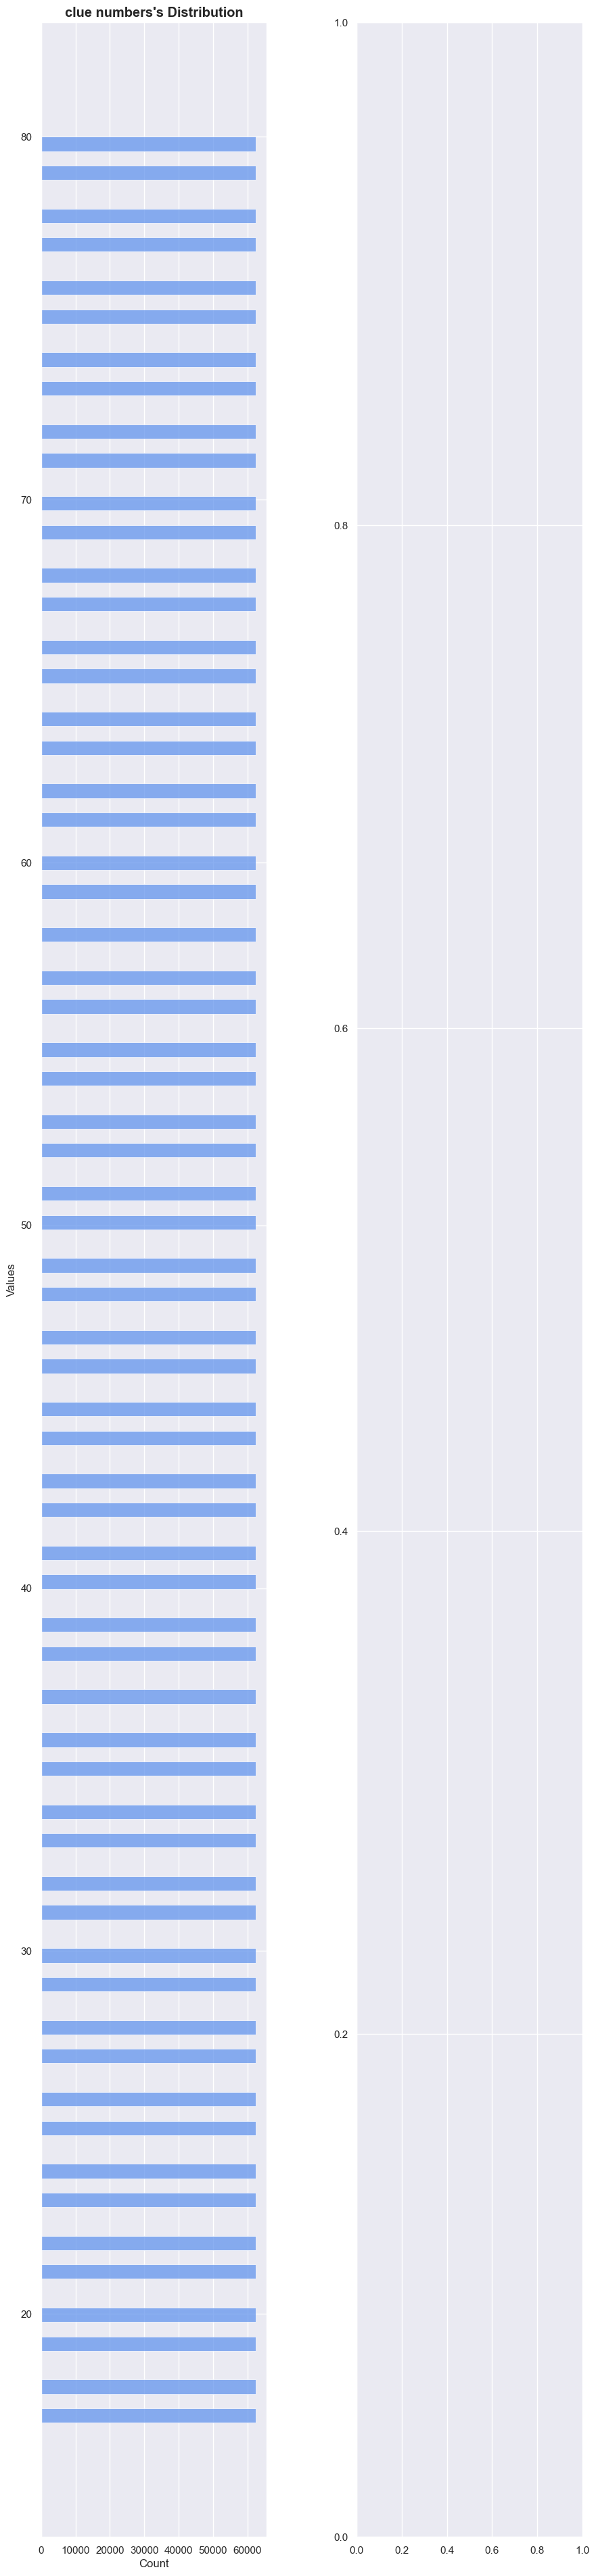

In [69]:
plot_frequency_distr_numeric(df)

### Data Sample

Here we can find the indices of the sudokus used for our benchmarks

In [12]:
set(csp_df['index'])

{58841,
 70313,
 73348,
 86823,
 122086,
 141831,
 162899,
 176818,
 214028,
 310912,
 315243,
 326819,
 353000,
 373052,
 387629,
 403622,
 457441,
 505500,
 529532,
 553197,
 589548,
 622331,
 634644,
 674138,
 685884,
 691597,
 694944,
 698154,
 711637,
 747391,
 777957,
 779023,
 804448,
 811773,
 895340,
 954179,
 957396,
 977138,
 991744,
 1062074,
 1073223,
 1077115,
 1096555,
 1133194,
 1174791,
 1188666,
 1201798,
 1221747,
 1225382,
 1246576,
 1308841,
 1320313,
 1323348,
 1336823,
 1372086,
 1391831,
 1412899,
 1426818,
 1464028,
 1560912,
 1565243,
 1576819,
 1603000,
 1623052,
 1637629,
 1653622,
 1707441,
 1755500,
 1779532,
 1803197,
 1839548,
 1872331,
 1884644,
 1924138,
 1935884,
 1941597,
 1944944,
 1948154,
 1961637,
 1997391,
 2027957,
 2029023,
 2054448,
 2061773,
 2145340,
 2204179,
 2207396,
 2227138,
 2241744,
 2312074,
 2323223,
 2327115,
 2346555,
 2383194,
 2424791,
 2438666,
 2451798,
 2471747,
 2475382,
 2496576,
 2536276,
 2541223,
 2543264,
 2573016,
 25

---

## Analysis of CSP Results

In [13]:
# Import the results for CSP
csp_df = pd.read_csv(CSP_DIR)

In [14]:
csp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     250 non-null    int64  
 1   clues                     250 non-null    int64  
 2   initialization_time_sec   250 non-null    float64
 3   execution_time_sec        250 non-null    float64
 4   min_cpu_usage_percentage  250 non-null    float64
 5   avg_cpu_usage_percentage  250 non-null    int64  
 6   max_cpu_usage_percentage  250 non-null    float64
 7   base_rss_usage_bytes      250 non-null    int64  
 8   min_rss_inc_bytes         250 non-null    int64  
 9   avg_rss_inc_bytes         250 non-null    int64  
 10  max_rss_inc_bytes         250 non-null    int64  
 11  base_vms_usage_bytes      250 non-null    int64  
 12  min_vms_inc_bytes         250 non-null    int64  
 13  avg_vms_inc_bytes         250 non-null    int64  
 14  max_vms_in

In [15]:
csp_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).describe()

index       clues  initialization_time_sec  execution_time_sec  \
count  2.500000e+02  250.000000               250.000000          250.000000   
mean   2.607656e+06   38.788000                 0.000819            0.035631   
std    1.214740e+06   19.430007                 0.000509            0.018321   
min    5.884100e+04   17.000000                 0.000500            0.001300   
25%    1.608013e+06   22.000000                 0.000700            0.020800   
50%    3.060335e+06   31.500000                 0.000700            0.037550   
75%    3.676263e+06   55.000000                 0.000800            0.051625   
max    3.997465e+06   80.000000                 0.004500            0.095400   

       min_cpu_usage_percentage  avg_cpu_usage_percentage  \
count                250.000000                250.000000   
mean                  65.943200                 65.488000   
std                   33.528304                 33.317655   
min                    0.000000                  0.000000   
25%                   33.200000                 33.000000   
50%                   66.500000                 66.000000   
75%                   99.700000                 99.000000   
max                  101.900000                101.000000   

       max_cpu_usage_percentage  base_rss_usage_bytes  min_rss_inc_bytes  \
count                250.000000          2.500000e+02         250.000000   
mean                  65.943200          1.227695e+09       24821.760000   
std                   33.528304          5.720714e+05       25931.504881   
min                    0.000000          1.226240e+09       20480.000000   
25%                   33.200000          1.227272e+09       20480.000000   
50%                   66.500000          1.227682e+09       20480.000000   
75%                   99.700000          1.227969e+09       20480.000000   
max                  101.900000          1.228616e+09      356352.000000   

       avg_rss_inc_bytes  ...  base_vms_usage_bytes  min_vms_inc_bytes  \
count         250.000000  ...          2.500000e+02       2.500000e+02   
mean        24821.760000  ...          1.712158e+09       5.387059e+04   
std         25931.504881  ...          3.751293e+05       6.669483e+04   
min         20480.000000  ...          1.710854e+09       4.915200e+04   
25%         20480.000000  ...          1.711907e+09       4.915200e+04   
50%         20480.000000  ...          1.712116e+09       4.915200e+04   
75%         20480.000000  ...          1.712251e+09       4.915200e+04   
max        356352.000000  ...          1.712796e+09       1.101824e+06   

       avg_vms_inc_bytes  max_vms_inc_bytes  recursive_calls  \
count       2.500000e+02       2.500000e+02        250.00000   
mean        5.387059e+04       5.387059e+04         35.32000   
std         6.669483e+04       6.669483e+04         18.87673   
min         4.915200e+04       4.915200e+04          2.00000   
25%         4.915200e+04       4.915200e+04         20.00000   
50%         4.915200e+04       4.915200e+04         34.00000   
75%         4.915200e+04       4.915200e+04         53.00000   
max         1.101824e+06       1.101824e+06         78.00000   

       backtracking_steps  forward_steps  ac3_revisions  ac3_contradictions  \
count          250.000000     250.000000     250.000000          250.000000   
mean            10.100000      31.860000     107.912000            3.820000   
std             20.027942      19.948538      93.103476            7.808681   
min              0.000000       1.000000       0.000000            0.000000   
25%              0.000000      15.000000      12.250000            0.000000   
50%              0.000000      29.500000      88.500000            0.000000   
75%              0.750000      51.750000     196.000000            0.750000   
max            109.000000      68.000000     299.000000           32.000000   

       mrv_invocations  
count        250.00000  
mean          35.32000  
std           18.87673  
mi

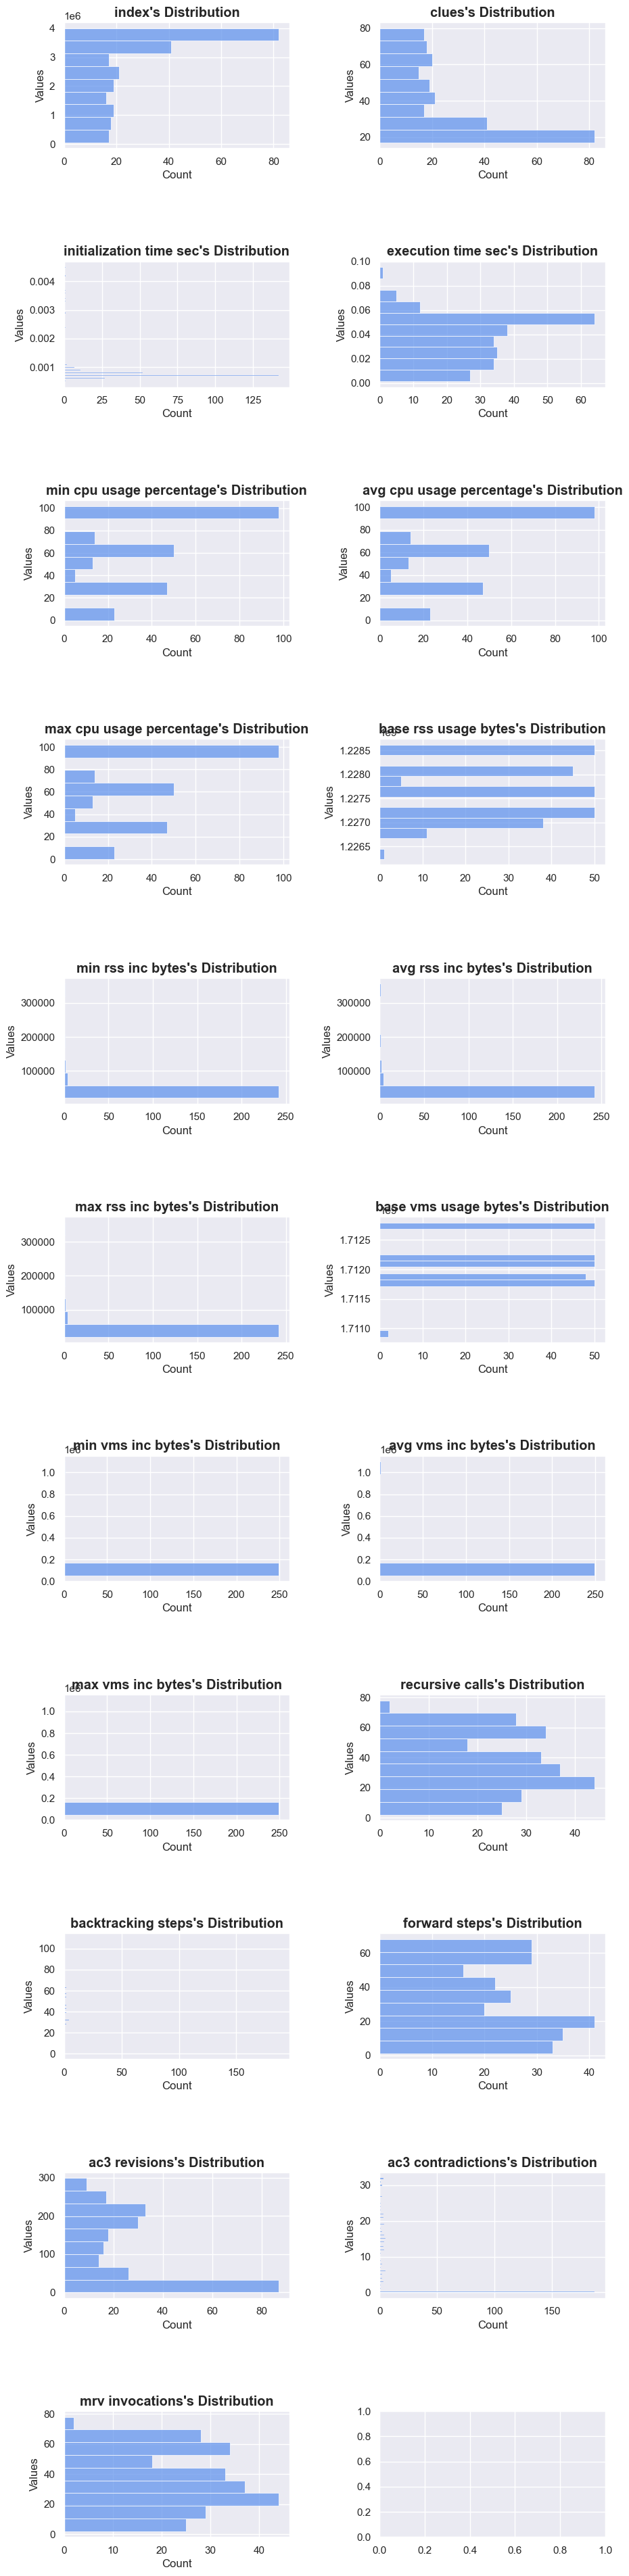

In [70]:
plot_frequency_distr_numeric(csp_df)

### Easy Puzzle Results

In [73]:
csp_df[(csp_df['clues'] >= 61) & (csp_df['clues'] <= 80)]

index  clues  initialization_time_sec  execution_time_sec  \
0     58841     80                   0.0007              0.0013   
1     70313     79                   0.0009              0.0022   
2     73348     79                   0.0006              0.0022   
3     86823     79                   0.0010              0.0028   
4    122086     79                   0.0007              0.0022   
5    141831     78                   0.0008              0.0031   
6    162899     78                   0.0009              0.0160   
7    176818     78                   0.0008              0.0031   
8    214028     77                   0.0008              0.0040   
9    310912     76                   0.0006              0.0050   
10   315243     75                   0.0034              0.0059   
11   326819     75                   0.0007              0.0059   
12   353000     75                   0.0006              0.0059   
13   373052     75                   0.0007              0.0060   
14   387629     74                   0.0007              0.0068   
15   403622     74                   0.0007              0.0070   
16   457441     73                   0.0006              0.0079   
17   505500     72                   0.0008              0.0215   
18   529532     72                   0.0006              0.0087   
19   553197     72                   0.0007              0.0087   
20   589548     71                   0.0005              0.0097   
21   622331     71                   0.0007              0.0097   
22   634644     70                   0.0006              0.0107   
23   674138     70                   0.0008              0.0105   
24   685884     70                   0.0007              0.0105   
25   691597     69                   0.0007              0.0115   
26   694944     69                   0.0007              0.0113   
27   698154     69                   0.0006              0.0115   
28   711637     69                   0.0007              0.0115   
29   747391     69                   0.0008              0.0113   
30   777957     68                   0.0011              0.0124   
31   779023     68                   0.0007              0.0252   
32   804448     68                   0.0007              0.0124   
33   811773     68                   0.0008              0.0122   
34   895340     66                   0.0008              0.0144   
35   954179     65                   0.0007              0.0151   
36   957396     65                   0.0006              0.0153   
37   977138     65                   0.0006              0.0151   
38   991744     65                   0.0008              0.0154   
39  1062074     64                   0.0007              0.0163   
40  1073223     63                   0.0007              0.0172   
41  1077115     63                   0.0008              0.0168   
42  1096555     63                   0.0007              0.0170   
43  1133194     62                   0.0007              0.0179   
44  1174791     62                   0.0036              0.0177   
45  1188666     61                   0.0007              0.0191   
46  1201798     61                   0.0007              0.0189   
47  1221747     61                   0.0008              0.0191   
48  1225382     61                   0.0007              0.0190   
49  1246576     61                   0.0010              0.0189   

    min_cpu_usage_percentage  avg_cpu_usage_percentage  \
0                        0.0                         0   
1                        0.0                         0   
2                        0.0                         0   
3                        0.0                         0   
4                        0.0                         0   
5                        0.0                         0   
6                       33.2                        33   
7                        0.0                         0   
8                        0.0                         0   
9       

### Medium Puzzle Results

In [74]:
csp_df[(csp_df['clues'] >= 41) & (csp_df['clues'] <= 60)]

index  clues  initialization_time_sec  execution_time_sec  \
50  1308841     60                   0.0007              0.0203   
51  1320313     59                   0.0007              0.0208   
52  1323348     59                   0.0007              0.0210   
53  1336823     59                   0.0008              0.0213   
54  1372086     59                   0.0007              0.0211   
55  1391831     58                   0.0008              0.0220   
56  1412899     58                   0.0007              0.0219   
57  1426818     58                   0.0007              0.0218   
58  1464028     57                   0.0007              0.0229   
59  1560912     56                   0.0007              0.0239   
60  1565243     55                   0.0007              0.0248   
61  1576819     55                   0.0011              0.0249   
62  1603000     55                   0.0007              0.0250   
63  1623052     55                   0.0007              0.0250   
64  1637629     54                   0.0008              0.0255   
65  1653622     54                   0.0007              0.0260   
66  1707441     53                   0.0007              0.0262   
67  1755500     52                   0.0007              0.0278   
68  1779532     52                   0.0007              0.0278   
69  1803197     52                   0.0007              0.0278   
70  1839548     51                   0.0007              0.0287   
71  1872331     51                   0.0007              0.0389   
72  1884644     50                   0.0007              0.0292   
73  1924138     50                   0.0007              0.0297   
74  1935884     50                   0.0007              0.0296   
75  1941597     49                   0.0007              0.0306   
76  1944944     49                   0.0007              0.0397   
77  1948154     49                   0.0007              0.0303   
78  1961637     49                   0.0007              0.0309   
79  1997391     49                   0.0009              0.0303   
80  2027957     48                   0.0007              0.0317   
81  2029023     48                   0.0007              0.0311   
82  2054448     48                   0.0008              0.0310   
83  2061773     48                   0.0008              0.0315   
84  2145340     46                   0.0024              0.0330   
85  2204179     45                   0.0007              0.0455   
86  2207396     45                   0.0008              0.0343   
87  2227138     45                   0.0007              0.0480   
88  2241744     45                   0.0007              0.0346   
89  2312074     44                   0.0007              0.0355   
90  2323223     43                   0.0009              0.0364   
91  2327115     43                   0.0007              0.0360   
92  2346555     43                   0.0007              0.0501   
93  2383194     42                   0.0008              0.0367   
94  2424791     42                   0.0007              0.0378   
95  2438666     41                   0.0007              0.0379   
96  2451798     41                   0.0007              0.0495   
97  2471747     41                   0.0007              0.0368   
98  2475382     41                   0.0007              0.0494   
99  2496576     41                   0.0006              0.0487   

    min_cpu_usage_percentage  avg_cpu_usage_percentage  \
50                      34.0                        34   
51                      50.4                        50   
52                      33.2                        33   
53                      33.2                        33   
54                      50.4                        50   
55                      50.4                        50   
56                      33.2                        33   
57                      66.5                        66   
58                      66.5                        66   
59      

### Hard Puzzle Results

In [75]:
csp_df[(csp_df['clues'] >= 26) & (csp_df['clues'] <= 40)]

index  clues  initialization_time_sec  execution_time_sec  \
100  2536276     40                   0.0007              0.0393   
101  2541223     40                   0.0008              0.0396   
102  2543264     40                   0.0008              0.0391   
103  2573016     39                   0.0008              0.0399   
104  2591453     39                   0.0008              0.0405   
105  2598042     39                   0.0007              0.0509   
106  2625182     38                   0.0007              0.0414   
107  2631040     38                   0.0008              0.0541   
108  2666576     38                   0.0007              0.0403   
109  2677179     38                   0.0007              0.0240   
110  2690806     37                   0.0007              0.0406   
111  2717632     37                   0.0007              0.0418   
112  2742198     37                   0.0007              0.0527   
113  2758132     36                   0.0008              0.0425   
114  2771863     36                   0.0010              0.0058   
115  2792602     36                   0.0008              0.0435   
116  2809637     36                   0.0007              0.0422   
117  2826589     35                   0.0007              0.0419   
118  2838926     35                   0.0008              0.0533   
119  2844983     35                   0.0007              0.0536   
120  2893603     34                   0.0007              0.0441   
121  2920391     34                   0.0007              0.0446   
122  2998867     33                   0.0007              0.0080   
123  3021871     32                   0.0006              0.0467   
124  3053759     32                   0.0008              0.0223   
125  3066911     31                   0.0007              0.0453   
126  3096939     31                   0.0007              0.0462   
127  3137016     30                   0.0009              0.0475   
128  3161806     30                   0.0007              0.0587   
129  3177073     30                   0.0007              0.0109   
130  3185358     30                   0.0007              0.0471   
131  3192520     29                   0.0008              0.0137   
132  3210145     29                   0.0007              0.0187   
133  3210951     29                   0.0008              0.0466   
134  3233185     29                   0.0007              0.0599   
135  3250889     28                   0.0007              0.0193   
136  3251921     28                   0.0006              0.0484   
137  3274603     28                   0.0007              0.0424   
138  3284297     28                   0.0007              0.0479   
139  3289919     28                   0.0007              0.0599   
140  3349878     27                   0.0007              0.0124   
141  3352158     27                   0.0006              0.0185   
142  3353977     27                   0.0008              0.0090   
143  3380604     26                   0.0033              0.0494   
144  3385127     26                   0.0008              0.0493   
145  3389775     26                   0.0007              0.0499   
146  3392954     26                   0.0010              0.0501   
147  3404037     26                   0.0042              0.0297   
148  3408319     26                   0.0008              0.0378   
149  3409197     26                   0.0006              0.0199   

     min_cpu_usage_percentage  avg_cpu_usage_percentage  \
100                      66.5                        66   
101                      66.5                        66   
102                      99.7                        99   
103                      66.5                        66   
104                      74.4                        74   
105                      99.2                        99   
106                      74.4                        74   
107                     100.8                       100   
108    

### Expert Puzzle Results

In [76]:
csp_df[(csp_df['clues'] >= 21) & (csp_df['clues'] <= 25)]

index  clues  initialization_time_sec  execution_time_sec  \
150  3449357     25                   0.0007              0.0109   
151  3460183     25                   0.0007              0.0534   
152  3469734     25                   0.0006              0.0602   
153  3480749     25                   0.0007              0.0505   
154  3480884     25                   0.0008              0.0337   
155  3481596     25                   0.0007              0.0503   
156  3481888     25                   0.0008              0.0216   
157  3482870     25                   0.0007              0.0183   
158  3491977     25                   0.0007              0.0501   
159  3499146     25                   0.0007              0.0037   
160  3499877     25                   0.0009              0.0506   
161  3516038     24                   0.0007              0.0616   
162  3516906     24                   0.0007              0.0208   
163  3518429     24                   0.0007              0.0511   
164  3522398     24                   0.0008              0.0510   
165  3527315     24                   0.0006              0.0373   
166  3536321     24                   0.0007              0.0544   
167  3553103     24                   0.0007              0.0509   
168  3568318     23                   0.0008              0.0417   
169  3577524     23                   0.0008              0.0524   
170  3579385     23                   0.0008              0.0518   
171  3593339     23                   0.0007              0.0243   
172  3610235     23                   0.0007              0.0625   
173  3611198     23                   0.0007              0.0344   
174  3616646     23                   0.0007              0.0360   
175  3622875     23                   0.0007              0.0518   
176  3625970     22                   0.0008              0.0238   
177  3634227     22                   0.0008              0.0332   
178  3641980     22                   0.0007              0.0526   
179  3642101     22                   0.0045              0.0327   
180  3642344     22                   0.0007              0.0676   
181  3645827     22                   0.0007              0.0241   
182  3652336     22                   0.0007              0.0292   
183  3653172     22                   0.0009              0.0529   
184  3653927     22                   0.0007              0.0640   
185  3654103     22                   0.0007              0.0531   
186  3666495     22                   0.0007              0.0466   
187  3679519     22                   0.0009              0.0534   
188  3681591     22                   0.0006              0.0635   
189  3689247     21                   0.0007              0.0304   
190  3691044     21                   0.0007              0.0448   
191  3695610     21                   0.0006              0.0228   
192  3713412     21                   0.0007              0.0409   
193  3718577     21                   0.0010              0.0239   
194  3720613     21                   0.0009              0.0530   
195  3731423     21                   0.0010              0.0535   
196  3735026     21                   0.0007              0.0537   
197  3739652     21                   0.0007              0.0533   
198  3739764     21                   0.0007              0.0539   
199  3744591     21                   0.0007              0.0416   

     min_cpu_usage_percentage  avg_cpu_usage_percentage  \
150                      33.2                        33   
151                      99.7                        99   
152                      99.2                        99   
153                      75.6                        75   
154                      66.5                        66   
155                      99.7                        99   
156                      33.2                        33   
157                      33.2                        33   
158    

### Legend Puzzle Results

In [77]:
csp_df[(csp_df['clues'] >= 17) & (csp_df['clues'] <= 20)]

index  clues  initialization_time_sec  execution_time_sec  \
200  3753954     20                   0.0006              0.0700   
201  3756124     20                   0.0008              0.0543   
202  3764438     20                   0.0007              0.0549   
203  3765501     20                   0.0007              0.0549   
204  3772049     20                   0.0007              0.0493   
205  3774629     20                   0.0007              0.0413   
206  3774991     20                   0.0007              0.0417   
207  3779675     20                   0.0006              0.0648   
208  3784524     20                   0.0009              0.0302   
209  3786726     20                   0.0007              0.0548   
210  3788489     20                   0.0008              0.0550   
211  3788683     20                   0.0009              0.0543   
212  3792897     20                   0.0007              0.0349   
213  3793700     20                   0.0007              0.0547   
214  3805779     20                   0.0008              0.0478   
215  3810727     20                   0.0007              0.0546   
216  3814939     19                   0.0007              0.0547   
217  3815707     19                   0.0007              0.0561   
218  3825959     19                   0.0007              0.0556   
219  3827431     19                   0.0008              0.0556   
220  3831627     19                   0.0007              0.0431   
221  3848055     19                   0.0007              0.0553   
222  3851078     19                   0.0037              0.0544   
223  3853296     19                   0.0007              0.0525   
224  3861013     19                   0.0006              0.0654   
225  3861499     19                   0.0007              0.0756   
226  3861626     19                   0.0006              0.0502   
227  3863368     19                   0.0008              0.0334   
228  3864951     19                   0.0029              0.0553   
229  3870291     19                   0.0008              0.0400   
230  3870374     19                   0.0008              0.0461   
231  3870449     19                   0.0010              0.0558   
232  3871661     19                   0.0007              0.0216   
233  3873691     19                   0.0008              0.0552   
234  3878856     18                   0.0007              0.0954   
235  3888104     18                   0.0008              0.0557   
236  3891990     18                   0.0007              0.0552   
237  3899303     18                   0.0006              0.0560   
238  3905476     18                   0.0007              0.0400   
239  3914553     18                   0.0007              0.0536   
240  3922861     18                   0.0007              0.0384   
241  3925429     18                   0.0008              0.0674   
242  3926728     18                   0.0006              0.0561   
243  3930179     18                   0.0006              0.0562   
244  3948904     17                   0.0008              0.0547   
245  3955283     17                   0.0007              0.0520   
246  3958704     17                   0.0008              0.0660   
247  3959306     17                   0.0007              0.0647   
248  3978764     17                   0.0006              0.0574   
249  3997465     17                   0.0006              0.0695   

     min_cpu_usage_percentage  avg_cpu_usage_percentage  \
200                     100.8                       100   
201                      99.7                        99   
202                      99.2                        99   
203                      99.7                        99   
204                      99.7                        99   
205                      99.7                        99   
206                      74.4                        74   
207                     100.8                       100   
208    

---

## Analysis of LSGA Results

In [17]:
# Import the results for LSGA
lsga_df = pd.read_csv(LSGA_DIR)

In [71]:
lsga_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).describe()

index       clues  initialization_time_sec  execution_time_sec  \
count  2.500000e+02  250.000000               250.000000          250.000000   
mean   2.607656e+06   38.788000                 0.000776           21.828396   
std    1.214740e+06   19.430007                 0.000233           24.962263   
min    5.884100e+04   17.000000                 0.000600            0.146200   
25%    1.608013e+06   22.000000                 0.000700            0.734250   
50%    3.060335e+06   31.500000                 0.000700            8.313350   
75%    3.676263e+06   55.000000                 0.000800           39.171425   
max    3.997465e+06   80.000000                 0.002500           74.606200   

       min_cpu_usage_percentage  avg_cpu_usage_percentage  \
count                250.000000                250.000000   
mean                  68.813600                 96.180000   
std                   37.104572                  9.300624   
min                    0.000000                 49.000000   
25%                   33.200000                 99.000000   
50%                   98.900000                 99.000000   
75%                   99.200000                100.000000   
max                  100.200000                103.000000   

       max_cpu_usage_percentage  base_rss_usage_bytes  min_rss_inc_bytes  \
count                250.000000          2.500000e+02         250.000000   
mean                 109.882000          1.228014e+09       21184.512000   
std                   11.395731          5.705452e+05       13714.727419   
min                   99.700000          1.227215e+09      -36864.000000   
25%                  101.900000          1.227543e+09       20480.000000   
50%                  101.900000          1.227739e+09       20480.000000   
75%                  124.000000          1.228308e+09       20480.000000   
max                  133.000000          1.229066e+09      212992.000000   

       avg_rss_inc_bytes  ...  avg_vms_inc_bytes  max_vms_inc_bytes  \
count         250.000000  ...         250.000000          250.00000   
mean        24250.952000  ...       50679.904000        51822.59200   
std         25342.035785  ...       17075.404155        18585.75651   
min        -13927.000000  ...      -14746.000000        49152.00000   
25%         20480.000000  ...       49152.000000        49152.00000   
50%         20480.000000  ...       49152.000000        49152.00000   
75%         20480.000000  ...       49152.000000        49152.00000   
max        235520.000000  ...      247403.000000       249856.00000   

       generations    row_swaps    cell_swaps  row_reinitializations  \
count   250.000000   250.000000    250.000000             250.000000   
mean     59.448000  1631.140000  29221.792000            4890.228000   
std      68.772479  1861.751272  33393.020589            5557.599351   
min       0.000000    12.000000      0.000000              61.000000   
25%       1.000000    59.500000    948.000000             174.250000   
50%      22.500000   623.500000  11442.000000            1888.500000   
75%     108.250000  2884.750000  53250.500000            8799.500000   
max     200.000000  5659.000000  97727.000000           16435.000000   

           col_swaps     sub_swaps  replacements  reinitializations  
count     250.000000    250.000000    250.000000         250.000000  
mean    41874.868000  16425.184000     38.324000          22.036000  
std     49489.968953  19177.149309     46.159352          24.005076  
min         0.000000      0.000000      0.000000           0.000000  
25%       787.250000    428.500000      1.000000           1.000000  
50%     15972.500000   6112.500000     14.000000          12.000000  
75%     75904.250000  29590.750000     69.000000          38.000000  
max    157803.000000  59964.000000    162.000000         105.000000  

[8 rows x 23 columns]

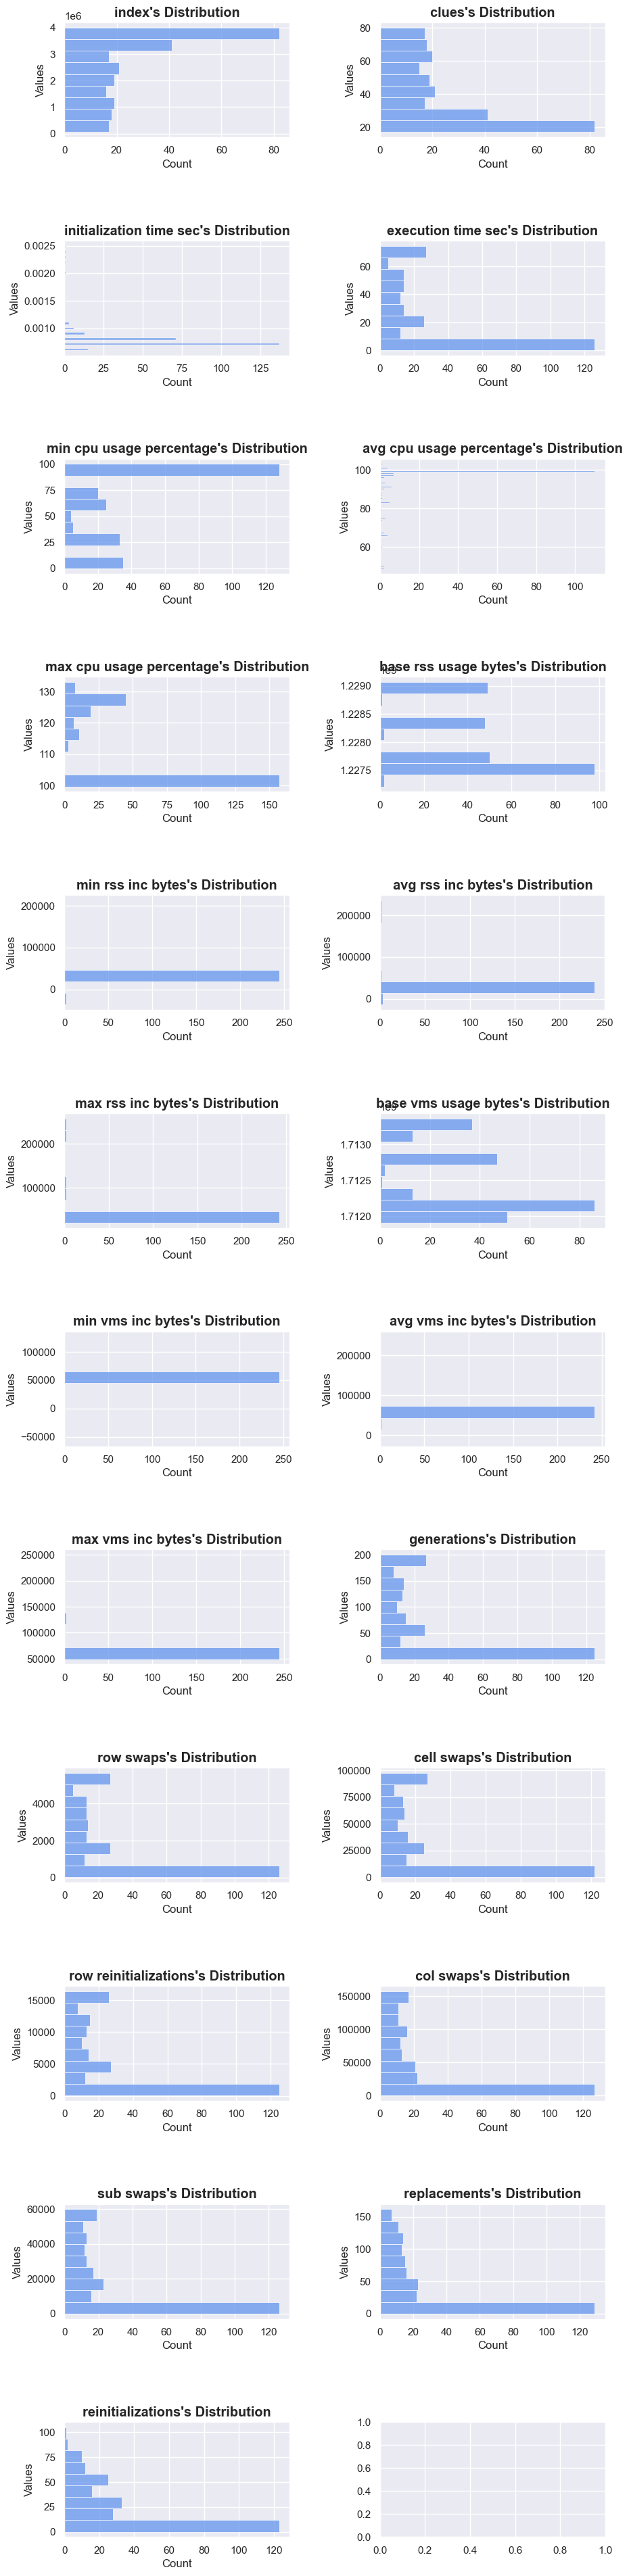

In [72]:
plot_frequency_distr_numeric(lsga_df)

### Easy Puzzle Results

In [78]:
lsga_df[(lsga_df['clues'] >= 61) & (lsga_df['clues'] <= 80)]

index  clues  initialization_time_sec  execution_time_sec  \
0     58841     80                   0.0009              0.1462   
1     70313     79                   0.0007              0.1493   
2     73348     79                   0.0007              0.1716   
3     86823     79                   0.0006              0.1891   
4    122086     79                   0.0007              0.1577   
5    141831     78                   0.0007              0.1638   
6    162899     78                   0.0007              0.1468   
7    176818     78                   0.0008              0.1678   
8    214028     77                   0.0007              0.1719   
9    310912     76                   0.0007              0.1986   
10   315243     75                   0.0006              0.1727   
11   326819     75                   0.0007              0.1977   
12   353000     75                   0.0007              0.1671   
13   373052     75                   0.0007              0.1763   
14   387629     74                   0.0009              0.2491   
15   403622     74                   0.0020              0.1685   
16   457441     73                   0.0007              0.1617   
17   505500     72                   0.0008              0.2535   
18   529532     72                   0.0007              0.1827   
19   553197     72                   0.0008              0.1652   
20   589548     71                   0.0011              0.2479   
21   622331     71                   0.0008              0.2622   
22   634644     70                   0.0006              0.2159   
23   674138     70                   0.0007              0.2556   
24   685884     70                   0.0007              0.2636   
25   691597     69                   0.0009              0.2760   
26   694944     69                   0.0007              0.2939   
27   698154     69                   0.0006              0.2962   
28   711637     69                   0.0007              0.2536   
29   747391     69                   0.0024              0.2892   
30   777957     68                   0.0007              0.2710   
31   779023     68                   0.0007              0.3706   
32   804448     68                   0.0007              0.2834   
33   811773     68                   0.0007              0.3061   
34   895340     66                   0.0007              0.3342   
35   954179     65                   0.0007              0.3253   
36   957396     65                   0.0008              0.3309   
37   977138     65                   0.0007              0.3012   
38   991744     65                   0.0007              0.3471   
39  1062074     64                   0.0007              0.3535   
40  1073223     63                   0.0007              0.3667   
41  1077115     63                   0.0010              0.3768   
42  1096555     63                   0.0007              0.3260   
43  1133194     62                   0.0007              0.3672   
44  1174791     62                   0.0007              0.6519   
45  1188666     61                   0.0007              0.3586   
46  1201798     61                   0.0007              0.6685   
47  1221747     61                   0.0006              0.3795   
48  1225382     61                   0.0009              0.3592   
49  1246576     61                   0.0007              0.3798   

    min_cpu_usage_percentage  avg_cpu_usage_percentage  \
0                       74.4                        87   
1                       99.7                        99   
2                       99.2                        99   
3                        0.0                        50   
4                        0.0                        49   
5                        0.0                        60   
6                       66.5                        83   
7                        0.0                        49   
8                       99.7                       100   
9       

### Medium Puzzle Results

In [79]:
lsga_df[(lsga_df['clues'] >= 41) & (lsga_df['clues'] <= 60)]

index  clues  initialization_time_sec  execution_time_sec  \
50  1308841     60                   0.0007              0.3654   
51  1320313     59                   0.0007              0.3752   
52  1323348     59                   0.0008              0.3587   
53  1336823     59                   0.0006              0.3912   
54  1372086     59                   0.0009              0.6825   
55  1391831     58                   0.0007              0.6309   
56  1412899     58                   0.0007              0.3990   
57  1426818     58                   0.0007              0.6402   
58  1464028     57                   0.0007              0.7263   
59  1560912     56                   0.0007              0.6912   
60  1565243     55                   0.0007              0.4131   
61  1576819     55                   0.0008              1.0303   
62  1603000     55                   0.0007              0.9862   
63  1623052     55                   0.0007              1.0370   
64  1637629     54                   0.0008              0.7315   
65  1653622     54                   0.0007              0.7425   
66  1707441     53                   0.0007              0.7109   
67  1755500     52                   0.0007              1.0815   
68  1779532     52                   0.0008              1.0183   
69  1803197     52                   0.0007              1.0347   
70  1839548     51                   0.0008              1.3735   
71  1872331     51                   0.0007              0.7585   
72  1884644     50                   0.0007              1.3465   
73  1924138     50                   0.0007              1.1083   
74  1935884     50                   0.0007              1.4223   
75  1941597     49                   0.0008              1.4609   
76  1944944     49                   0.0007              1.7137   
77  1948154     49                   0.0007              1.1380   
78  1961637     49                   0.0007              1.3971   
79  1997391     49                   0.0008              1.3981   
80  2027957     48                   0.0007              1.7246   
81  2029023     48                   0.0007              1.7529   
82  2054448     48                   0.0007              1.4155   
83  2061773     48                   0.0008              1.7794   
84  2145340     46                   0.0006              1.8041   
85  2204179     45                   0.0007              1.4890   
86  2207396     45                   0.0007              2.5130   
87  2227138     45                   0.0007              1.7894   
88  2241744     45                   0.0007              2.1579   
89  2312074     44                   0.0007              3.4748   
90  2323223     43                   0.0008              2.7915   
91  2327115     43                   0.0007              1.8132   
92  2346555     43                   0.0007              2.7653   
93  2383194     42                   0.0008              3.5107   
94  2424791     42                   0.0007              2.8621   
95  2438666     41                   0.0009              3.4928   
96  2451798     41                   0.0007              3.0989   
97  2471747     41                   0.0007              2.5486   
98  2475382     41                   0.0007              4.4032   
99  2496576     41                   0.0007              3.1721   

    min_cpu_usage_percentage  avg_cpu_usage_percentage  \
50                      99.2                        99   
51                      99.2                        99   
52                      74.4                        93   
53                      99.2                        99   
54                      99.2                       100   
55                      99.2                       100   
56                      99.7                       100   
57                      33.2                        90   
58                      24.8                        91   
59      

### Hard Puzzle Results

In [80]:
lsga_df[(lsga_df['clues'] >= 26) & (lsga_df['clues'] <= 40)]

index  clues  initialization_time_sec  execution_time_sec  \
100  2536276     40                   0.0007              3.7975   
101  2541223     40                   0.0009              3.8746   
102  2543264     40                   0.0007              3.1702   
103  2573016     39                   0.0011              3.9443   
104  2591453     39                   0.0008              5.6517   
105  2598042     39                   0.0007              4.8430   
106  2625182     38                   0.0007              4.2890   
107  2631040     38                   0.0008              5.8786   
108  2666576     38                   0.0008              4.8640   
109  2677179     38                   0.0007              3.8310   
110  2690806     37                   0.0007              7.0902   
111  2717632     37                   0.0008              4.0425   
112  2742198     37                   0.0007              4.3128   
113  2758132     36                   0.0008              6.0775   
114  2771863     36                   0.0008              5.6956   
115  2792602     36                   0.0007              7.4089   
116  2809637     36                   0.0010              8.0628   
117  2826589     35                   0.0022              5.4401   
118  2838926     35                   0.0007              5.8093   
119  2844983     35                   0.0008              5.3501   
120  2893603     34                   0.0008              5.0959   
121  2920391     34                   0.0010             21.8692   
122  2998867     33                   0.0009              8.2329   
123  3021871     32                   0.0007             20.0910   
124  3053759     32                   0.0008             12.7512   
125  3066911     31                   0.0007              8.3565   
126  3096939     31                   0.0010             22.7952   
127  3137016     30                   0.0008             10.0538   
128  3161806     30                   0.0007             17.0330   
129  3177073     30                   0.0008             14.1655   
130  3185358     30                   0.0008             28.5317   
131  3192520     29                   0.0006             67.9572   
132  3210145     29                   0.0007             39.3683   
133  3210951     29                   0.0007             15.0013   
134  3233185     29                   0.0007             20.2018   
135  3250889     28                   0.0008             18.4110   
136  3251921     28                   0.0008             22.0028   
137  3274603     28                   0.0008             18.9647   
138  3284297     28                   0.0008             17.0948   
139  3289919     28                   0.0007             18.9453   
140  3349878     27                   0.0008             24.8387   
141  3352158     27                   0.0007              8.2702   
142  3353977     27                   0.0007             14.2058   
143  3380604     26                   0.0008             29.4694   
144  3385127     26                   0.0008             33.2867   
145  3389775     26                   0.0007             22.3828   
146  3392954     26                   0.0007             15.2384   
147  3404037     26                   0.0007             70.5629   
148  3408319     26                   0.0007             23.6815   
149  3409197     26                   0.0007             48.6368   

     min_cpu_usage_percentage  avg_cpu_usage_percentage  \
100                      99.2                        99   
101                      66.5                        99   
102                      99.2                        99   
103                      66.5                        99   
104                       0.0                        98   
105                      99.2                        99   
106                      99.2                       100   
107                       0.0                        98   
108    

### Expert Puzzle Results

In [81]:
lsga_df[(lsga_df['clues'] >= 21) & (lsga_df['clues'] <= 25)]

index  clues  initialization_time_sec  execution_time_sec  \
150  3449357     25                   0.0007             30.5834   
151  3460183     25                   0.0008             26.6704   
152  3469734     25                   0.0007             16.6200   
153  3480749     25                   0.0008             27.8515   
154  3480884     25                   0.0007             34.8393   
155  3481596     25                   0.0025             68.7499   
156  3481888     25                   0.0008             57.9389   
157  3482870     25                   0.0008             12.4932   
158  3491977     25                   0.0007             39.1922   
159  3499146     25                   0.0007             70.8658   
160  3499877     25                   0.0006             18.4558   
161  3516038     24                   0.0007             37.0532   
162  3516906     24                   0.0007             70.6393   
163  3518429     24                   0.0008             38.1018   
164  3522398     24                   0.0007             18.2070   
165  3527315     24                   0.0007              4.8887   
166  3536321     24                   0.0007             41.6273   
167  3553103     24                   0.0008             27.8126   
168  3568318     23                   0.0007             57.8198   
169  3577524     23                   0.0008             38.1873   
170  3579385     23                   0.0007             34.8261   
171  3593339     23                   0.0008             19.1775   
172  3610235     23                   0.0007             21.8621   
173  3611198     23                   0.0008             52.2330   
174  3616646     23                   0.0008             42.6565   
175  3622875     23                   0.0007             17.4301   
176  3625970     22                   0.0009             66.9678   
177  3634227     22                   0.0011             14.1486   
178  3641980     22                   0.0007             72.6122   
179  3642101     22                   0.0007             59.5939   
180  3642344     22                   0.0007             56.5201   
181  3645827     22                   0.0008             41.2969   
182  3652336     22                   0.0006             69.5482   
183  3653172     22                   0.0007             56.3280   
184  3653927     22                   0.0008             49.4896   
185  3654103     22                   0.0008             24.6256   
186  3666495     22                   0.0006             15.7992   
187  3679519     22                   0.0007             60.0567   
188  3681591     22                   0.0007             72.5222   
189  3689247     21                   0.0007             48.1098   
190  3691044     21                   0.0007             67.3843   
191  3695610     21                   0.0008             30.5427   
192  3713412     21                   0.0007             73.8383   
193  3718577     21                   0.0006             10.4255   
194  3720613     21                   0.0008             73.3173   
195  3731423     21                   0.0007             41.8701   
196  3735026     21                   0.0007             23.1523   
197  3739652     21                   0.0008             20.5565   
198  3739764     21                   0.0008             25.2803   
199  3744591     21                   0.0007             35.7448   

     min_cpu_usage_percentage  avg_cpu_usage_percentage  \
150                      33.2                        99   
151                      99.2                        99   
152                      99.2                        99   
153                      99.2                       100   
154                      99.2                       100   
155                      98.9                       100   
156                      99.2                       100   
157                      66.5                        99   
158    

### Legend Puzzle Results

In [82]:
lsga_df[(lsga_df['clues'] >= 17) & (lsga_df['clues'] <= 20)]

index  clues  initialization_time_sec  execution_time_sec  \
200  3753954     20                   0.0007             72.6881   
201  3756124     20                   0.0010             14.3675   
202  3764438     20                   0.0008             51.6748   
203  3765501     20                   0.0007             38.8662   
204  3772049     20                   0.0007             52.1550   
205  3774629     20                   0.0007             26.1559   
206  3774991     20                   0.0008             42.4593   
207  3779675     20                   0.0010             28.1719   
208  3784524     20                   0.0008             73.3012   
209  3786726     20                   0.0007             56.5692   
210  3788489     20                   0.0007             50.1648   
211  3788683     20                   0.0006             43.1708   
212  3792897     20                   0.0008             20.8287   
213  3793700     20                   0.0007             29.2862   
214  3805779     20                   0.0007             46.1329   
215  3810727     20                   0.0008             72.5798   
216  3814939     19                   0.0008             71.1437   
217  3815707     19                   0.0007             49.5832   
218  3825959     19                   0.0008             23.7934   
219  3827431     19                   0.0007             64.0850   
220  3831627     19                   0.0007             73.2436   
221  3848055     19                   0.0008             66.3298   
222  3851078     19                   0.0009             48.9537   
223  3853296     19                   0.0009             72.4581   
224  3861013     19                   0.0007             50.2815   
225  3861499     19                   0.0008             31.6743   
226  3861626     19                   0.0007             32.5832   
227  3863368     19                   0.0008             47.5864   
228  3864951     19                   0.0008             73.4194   
229  3870291     19                   0.0008             52.0924   
230  3870374     19                   0.0007             21.0593   
231  3870449     19                   0.0007             73.4836   
232  3871661     19                   0.0006             74.6062   
233  3873691     19                   0.0008             19.3473   
234  3878856     18                   0.0007             39.1091   
235  3888104     18                   0.0008             73.7060   
236  3891990     18                   0.0007             32.3242   
237  3899303     18                   0.0007             20.7581   
238  3905476     18                   0.0009             73.2717   
239  3914553     18                   0.0008             45.6621   
240  3922861     18                   0.0006             64.1192   
241  3925429     18                   0.0008             43.8196   
242  3926728     18                   0.0008             72.2745   
243  3930179     18                   0.0008             55.8285   
244  3948904     17                   0.0008              7.7861   
245  3955283     17                   0.0007             74.5151   
246  3958704     17                   0.0009             55.5908   
247  3959306     17                   0.0008             73.7412   
248  3978764     17                   0.0023             74.4220   
249  3997465     17                   0.0007             57.2394   

     min_cpu_usage_percentage  avg_cpu_usage_percentage  \
200                      99.2                       100   
201                      99.2                        99   
202                      66.5                        99   
203                      66.5                       100   
204                      66.5                        99   
205                      99.2                        99   
206                      99.2                       100   
207                      98.9                       100   
208    

---

## Comparative Analysis of CSP approach and LSGA approach

Here we check what metrics are correlated the most with the number of clues to inspect which common metric may suggest improvement.

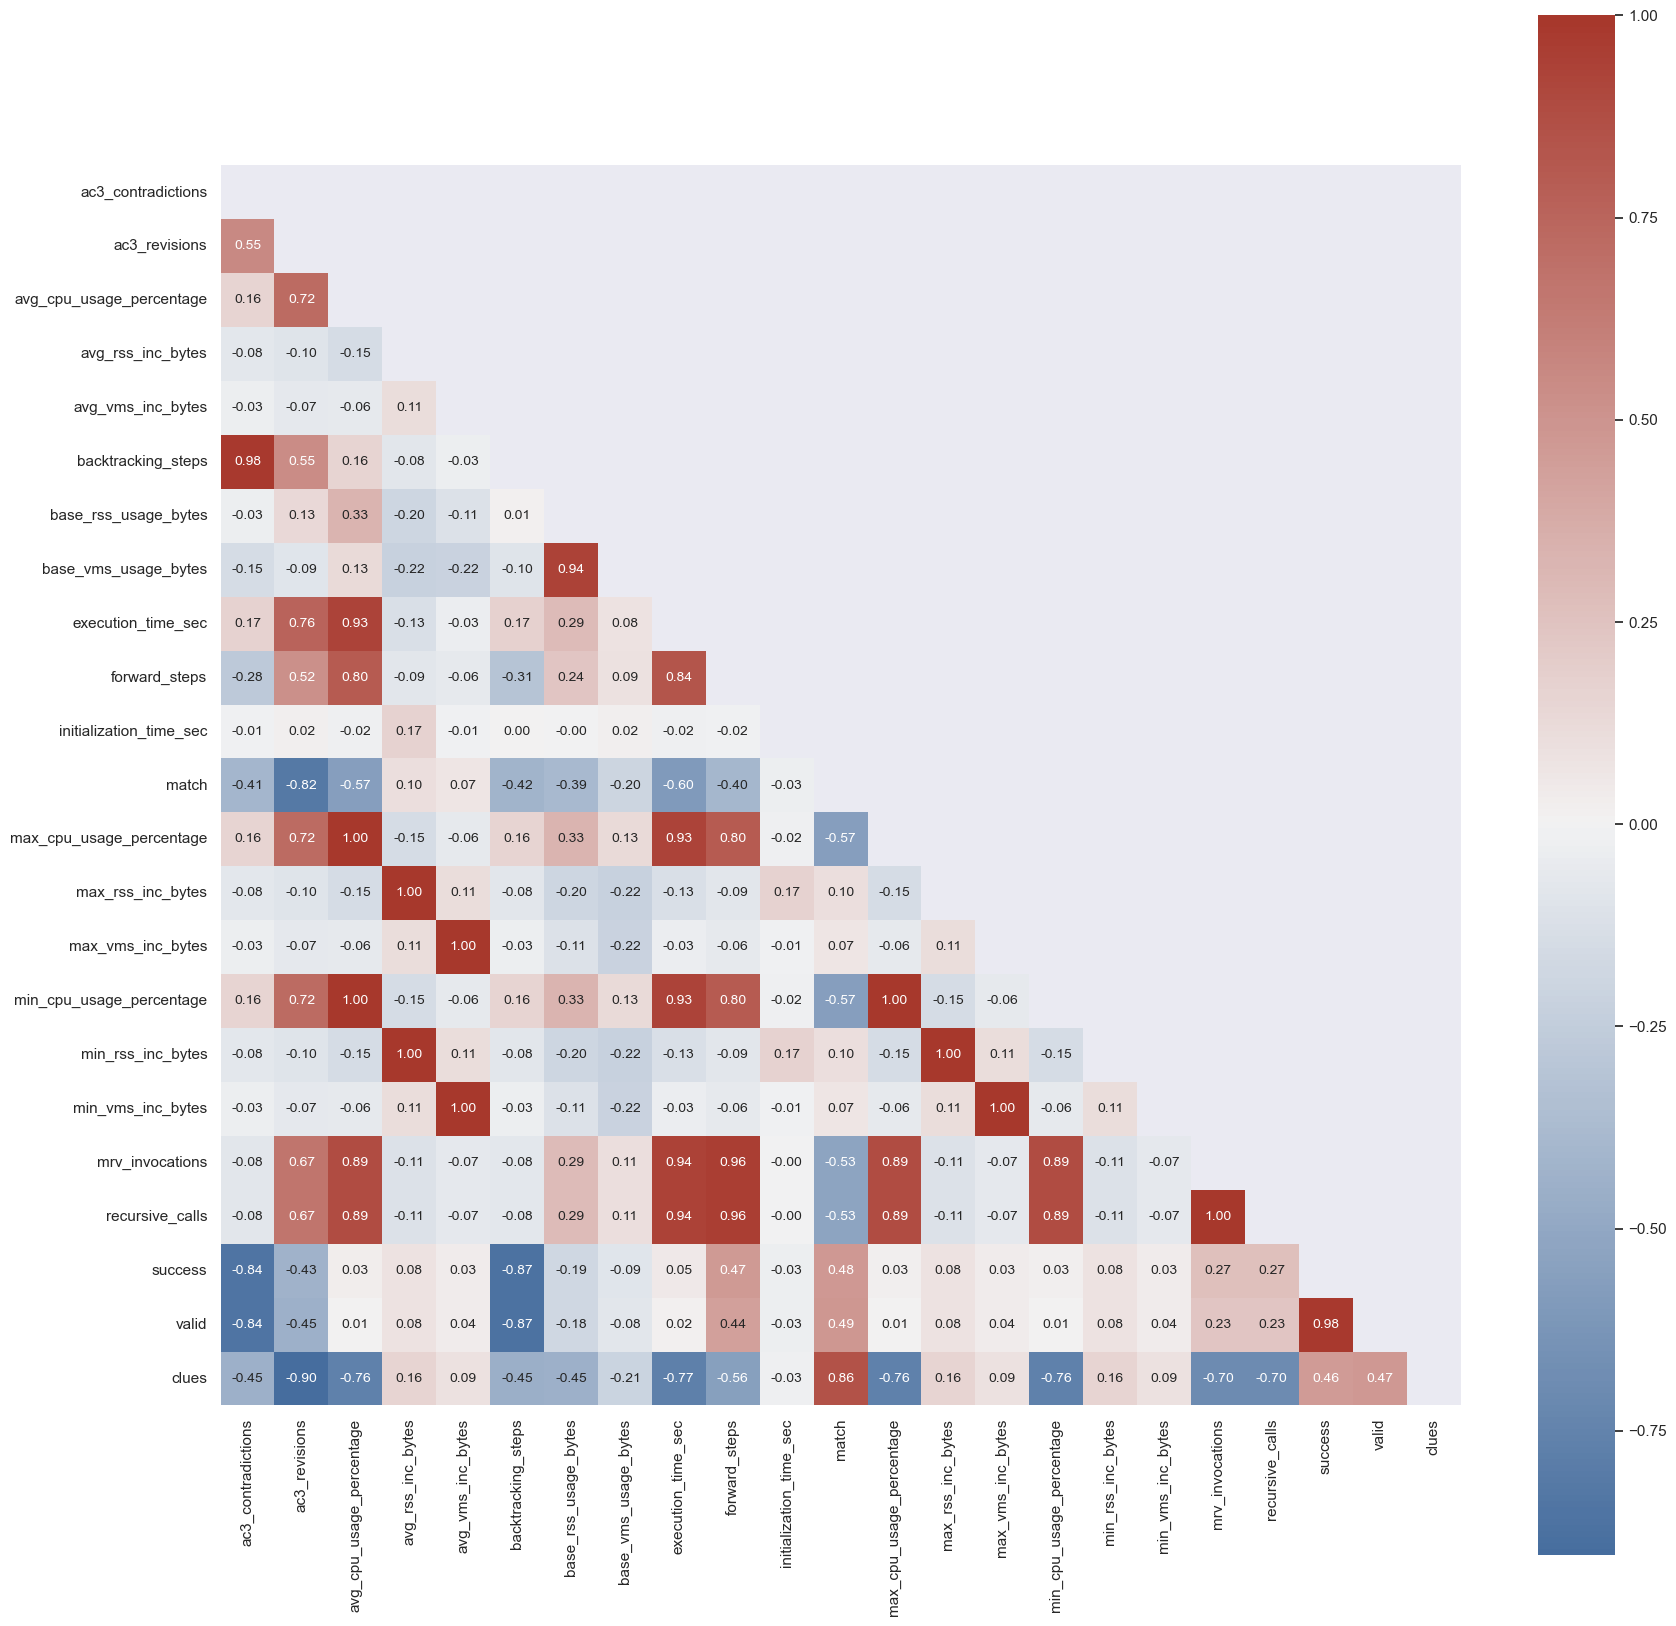

In [18]:
corr_CSP = display_corr_matrix(sort_alphabetically(csp_df.drop(columns=['index']), 'clues'), label='clues')

In [19]:
top_corr_dict_CSP = top_correlated_features(corr_CSP, 'clues', 0.40)
top_corr_dict_CSP

{'match': 0.8565764840803612,
 'valid': 0.47305363663808647,
 'success': 0.46062866816309744,
 'base_rss_usage_bytes': -0.44711679002489435,
 'ac3_contradictions': -0.4486237952840515,
 'backtracking_steps': -0.45206633686227526,
 'forward_steps': -0.5587508767589344,
 'mrv_invocations': -0.6989505898760451,
 'recursive_calls': -0.6989505898760451,
 'max_cpu_usage_percentage': -0.7630252479535083,
 'min_cpu_usage_percentage': -0.7630252479535083,
 'avg_cpu_usage_percentage': -0.7631657869465757,
 'execution_time_sec': -0.7711826661635063,
 'ac3_revisions': -0.9039861011038952}

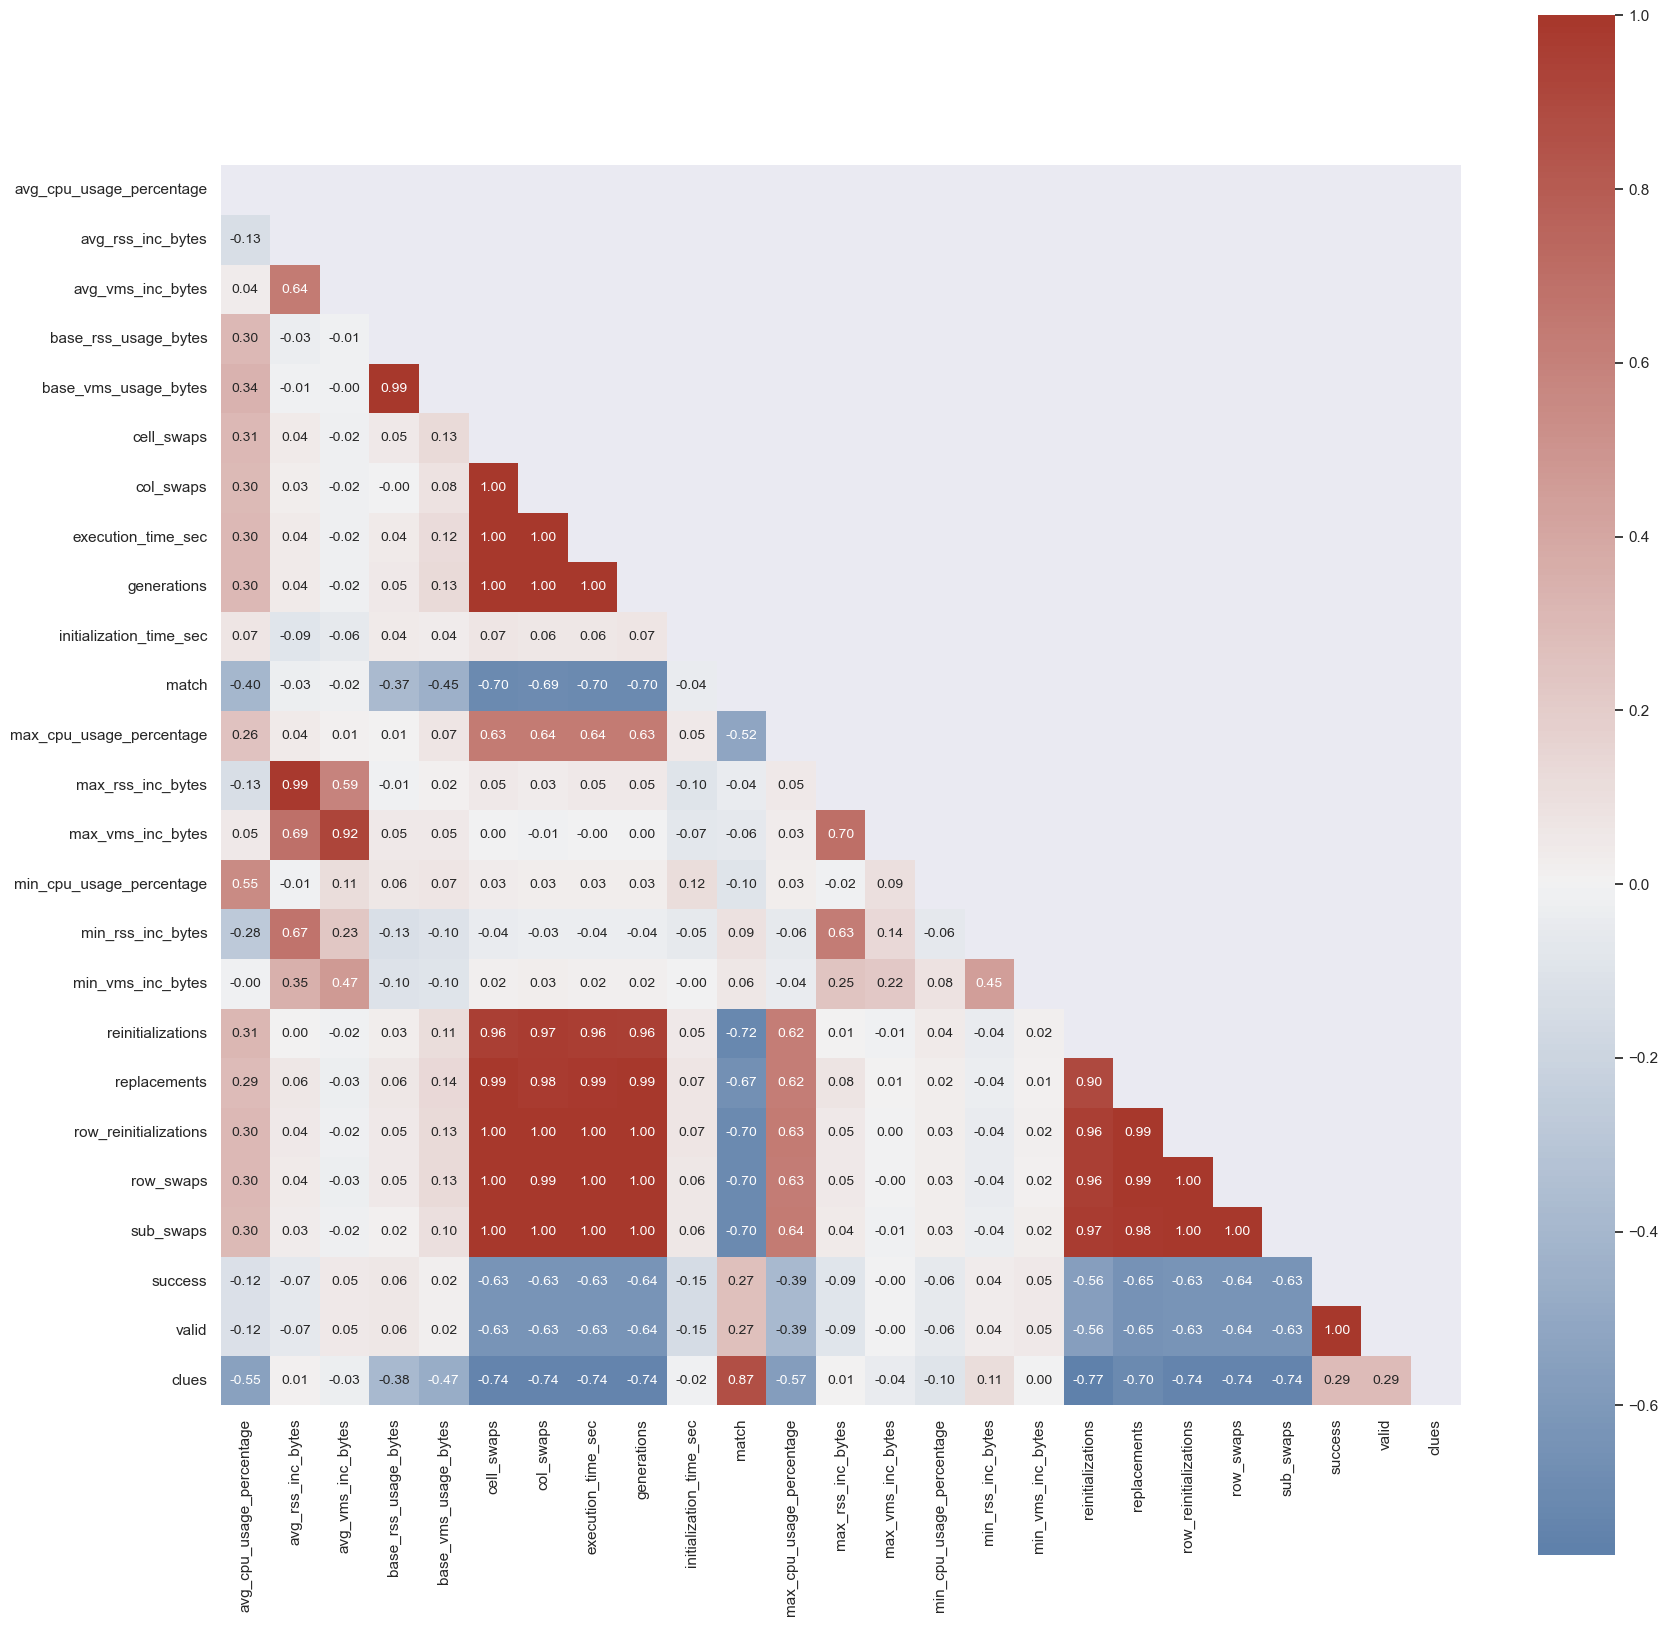

In [20]:
corr_LSGA = display_corr_matrix(sort_alphabetically(lsga_df.drop(columns=['index']), 'clues'), label='clues')

In [21]:
top_corr_dict_LSGA = top_correlated_features(corr_LSGA, 'clues', 0.40)
top_corr_dict_LSGA

{'match': 0.8654886540693458,
 'base_vms_usage_bytes': -0.4721741970606487,
 'avg_cpu_usage_percentage': -0.549090233624112,
 'max_cpu_usage_percentage': -0.5748217060423837,
 'replacements': -0.7002877095439743,
 'row_swaps': -0.7382148797355259,
 'col_swaps': -0.7386247204626287,
 'sub_swaps': -0.7403379026829826,
 'generations': -0.7409223236976532,
 'row_reinitializations': -0.74155856076049,
 'execution_time_sec': -0.742724295075593,
 'cell_swaps': -0.74351203513859,
 'reinitializations': -0.7726831629818598}

In [22]:
top_corr_dict = set(top_corr_dict_CSP.keys()) & set(top_corr_dict_LSGA.keys()) 
top_corr_dict

{'avg_cpu_usage_percentage',
 'execution_time_sec',
 'match',
 'max_cpu_usage_percentage'}

As we can see the common correlated metrics are CPU Usage, and the 'match' column which specifies whether the algorithm managed to find the solution provided by the dataset, on its own.

### Execution Time

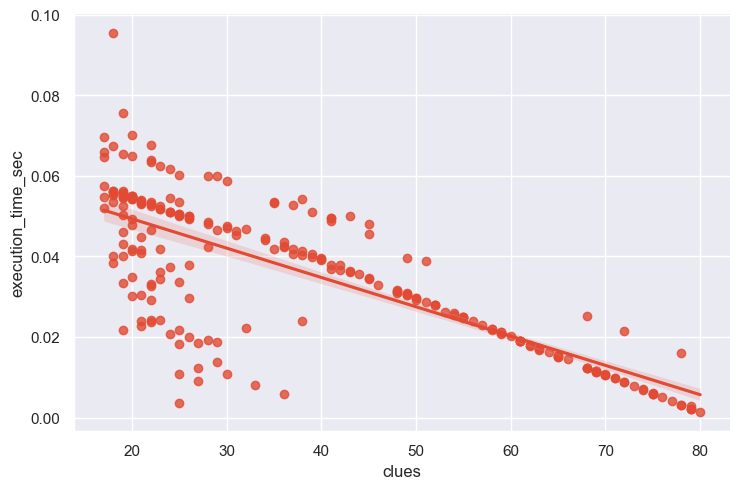

In [23]:
scatterplot_single(csp_df, 'clues', 'execution_time_sec')

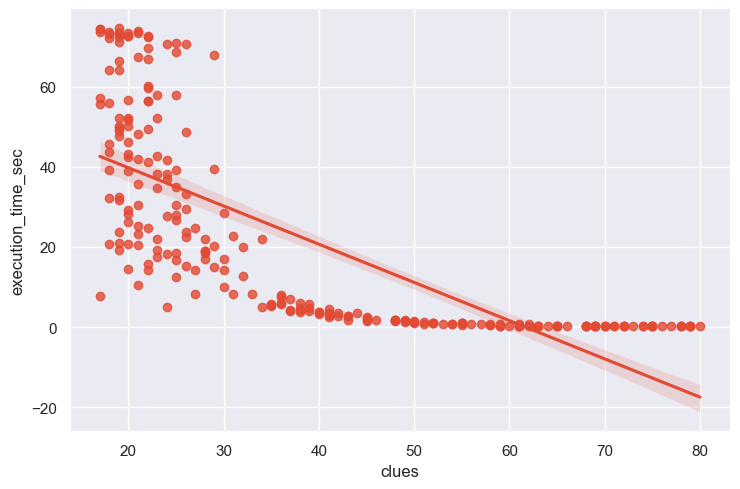

In [24]:
scatterplot_single(lsga_df, 'clues', 'execution_time_sec')

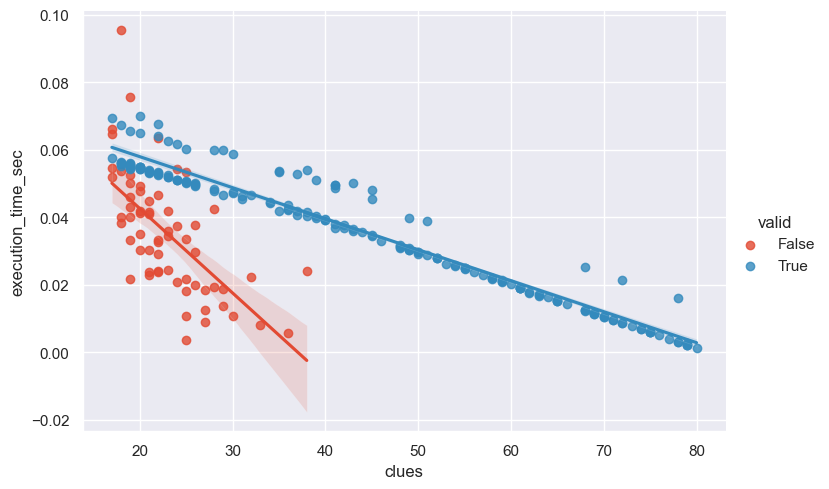

In [25]:
scatterplot_single(csp_df, 'clues', 'execution_time_sec', hue='valid')

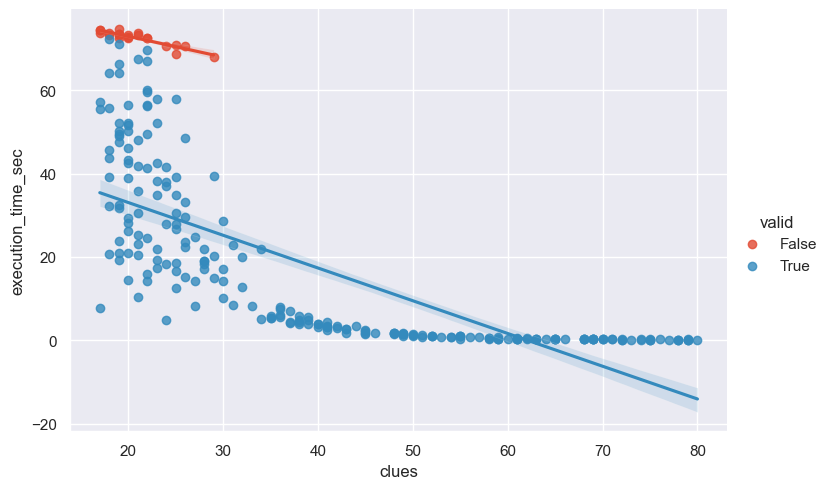

In [26]:
scatterplot_single(lsga_df, 'clues', 'execution_time_sec', hue='valid')

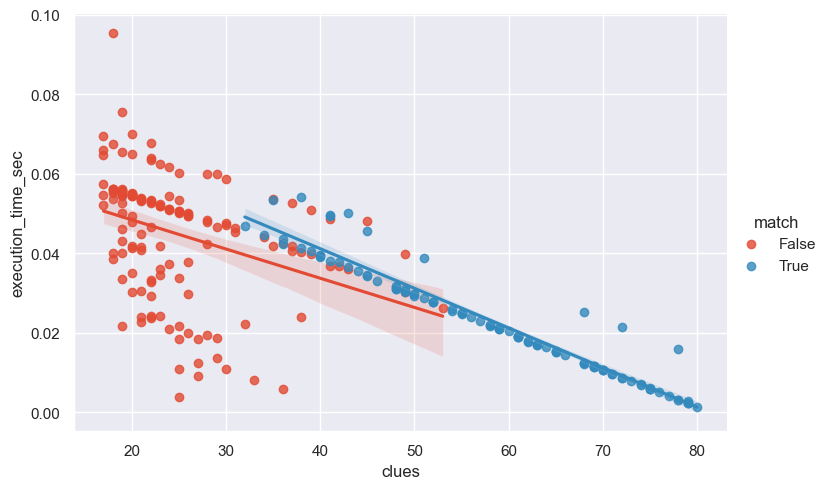

In [27]:
scatterplot_single(csp_df, 'clues', 'execution_time_sec', hue='match')

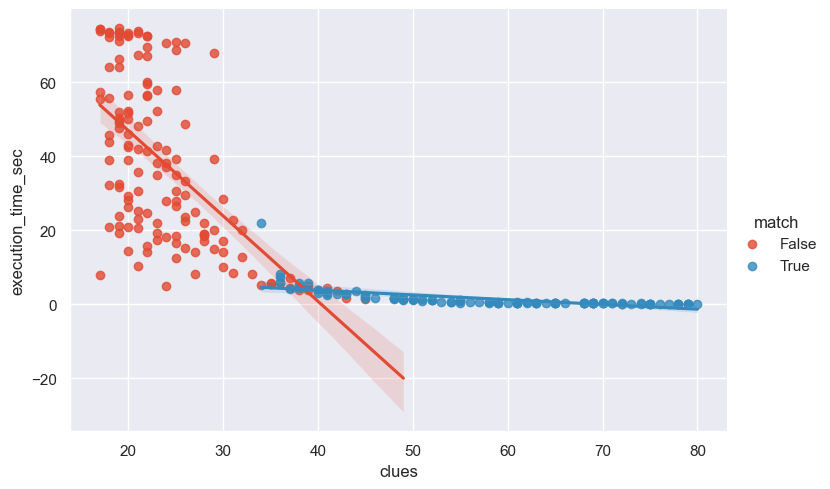

In [28]:
scatterplot_single(lsga_df, 'clues', 'execution_time_sec', hue='match')

While being incredibly faster, MAC struggles to achieve valid solutions and does not often find a unique solution. On the other hand, the slower approach of LSGA is more robust to hard puzzle although it becomes extremely slow with less than 40 clues inside the Sudoku.

### Average CPU Usage

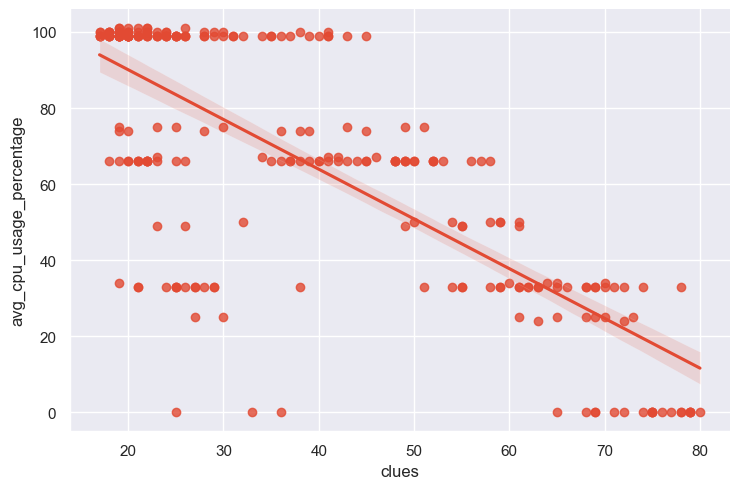

In [29]:
scatterplot_single(csp_df, 'clues', 'avg_cpu_usage_percentage')

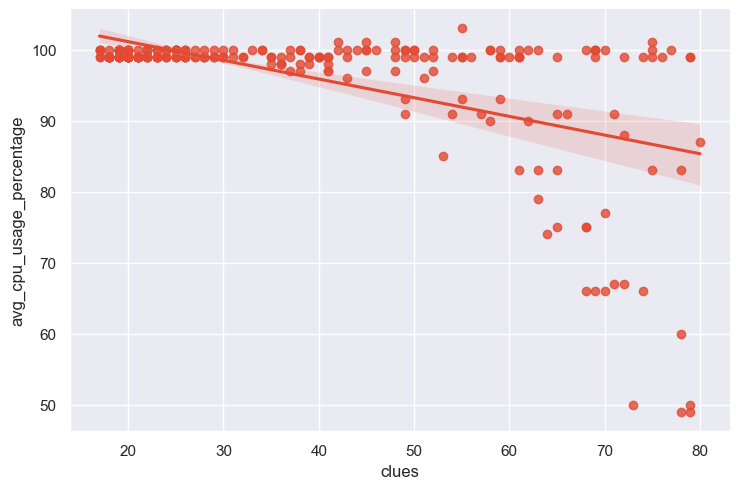

In [30]:
scatterplot_single(lsga_df, 'clues', 'avg_cpu_usage_percentage')

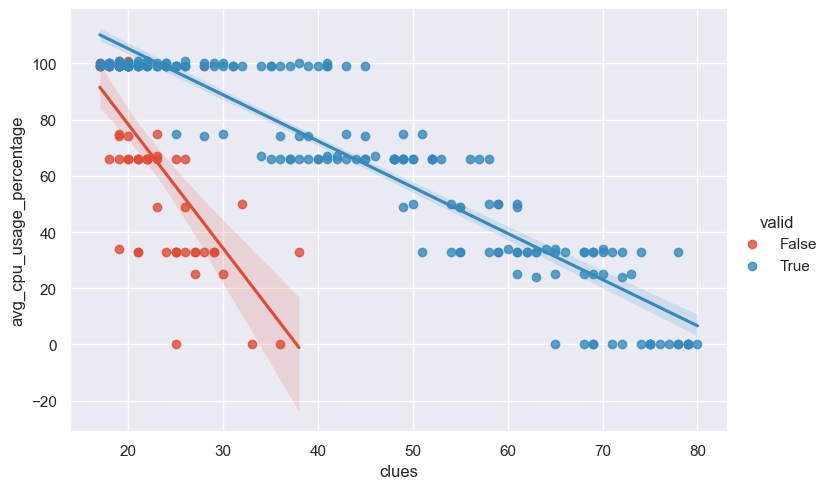

In [31]:
scatterplot_single(csp_df, 'clues', 'avg_cpu_usage_percentage', hue='valid')

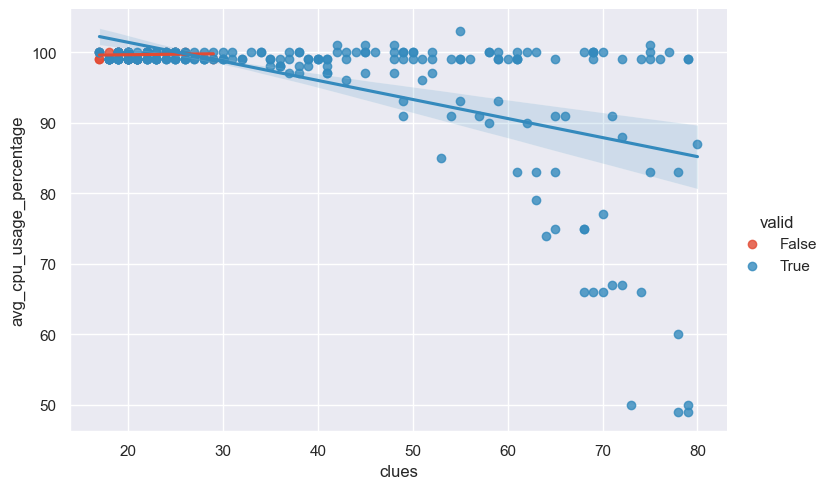

In [32]:
scatterplot_single(lsga_df, 'clues', 'avg_cpu_usage_percentage', hue='valid')

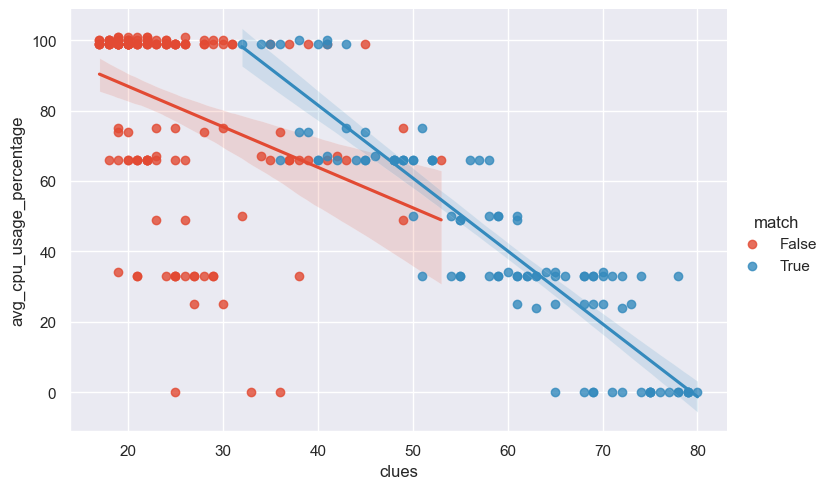

In [33]:
scatterplot_single(csp_df, 'clues', 'avg_cpu_usage_percentage', hue='match')

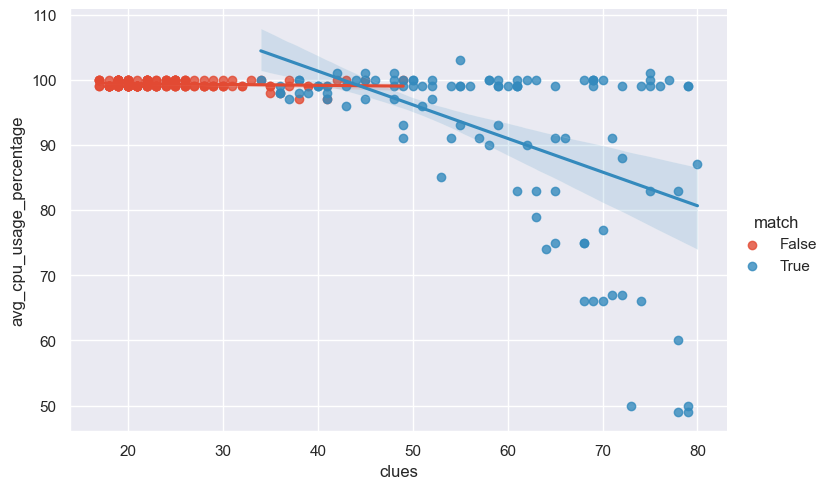

In [34]:
scatterplot_single(lsga_df, 'clues', 'avg_cpu_usage_percentage', hue='match')

The average CPU usage is fairly high when using LSGA as it continuously maintains many data structures and implies repetitive global checks. It is curious to notice that, although memory usage remains almost constant, there are cases where the solution require very low computation power.
However, MAC has an impressive decrease of computational power when clues are more than 40. This still needs to account for the lack of valid answers, which cannot be justified by the rapidity of convergence.

### Max CPU Usage

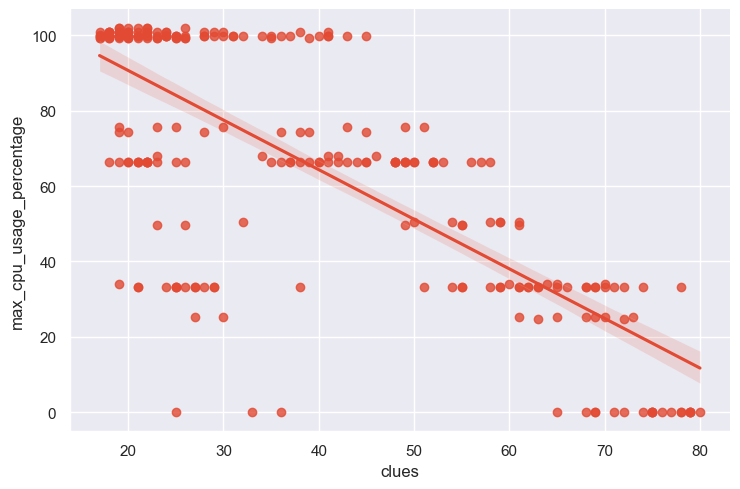

In [35]:
scatterplot_single(csp_df, 'clues', 'max_cpu_usage_percentage')

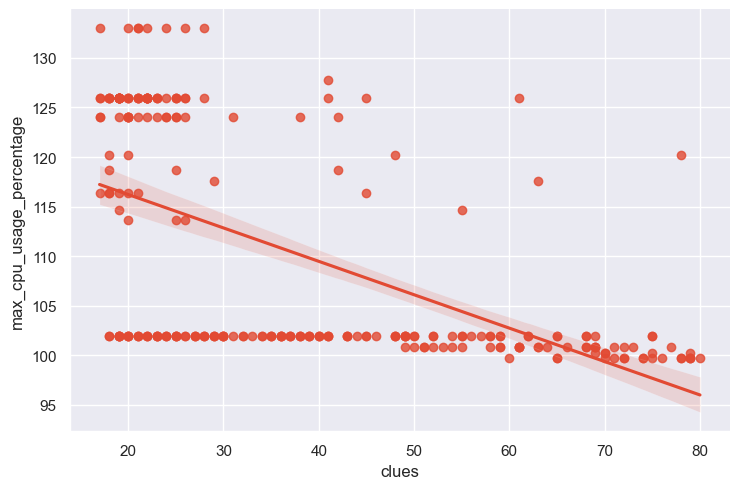

In [36]:
scatterplot_single(lsga_df, 'clues', 'max_cpu_usage_percentage')

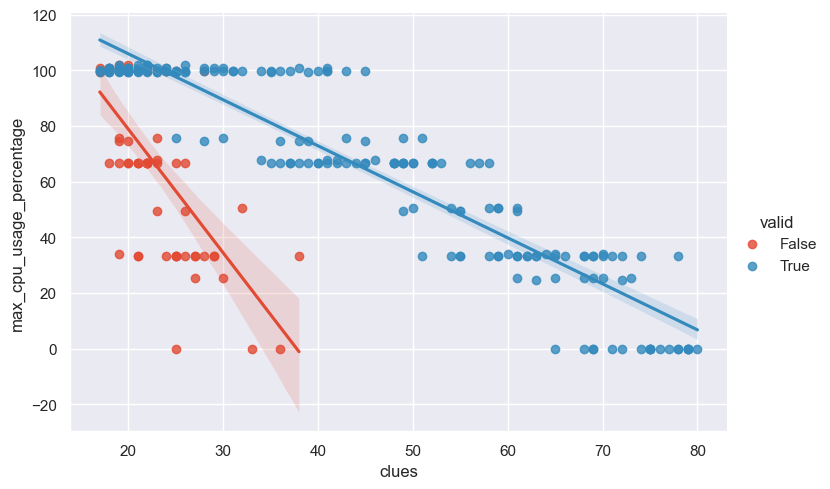

In [37]:
scatterplot_single(csp_df, 'clues', 'max_cpu_usage_percentage', hue='valid')

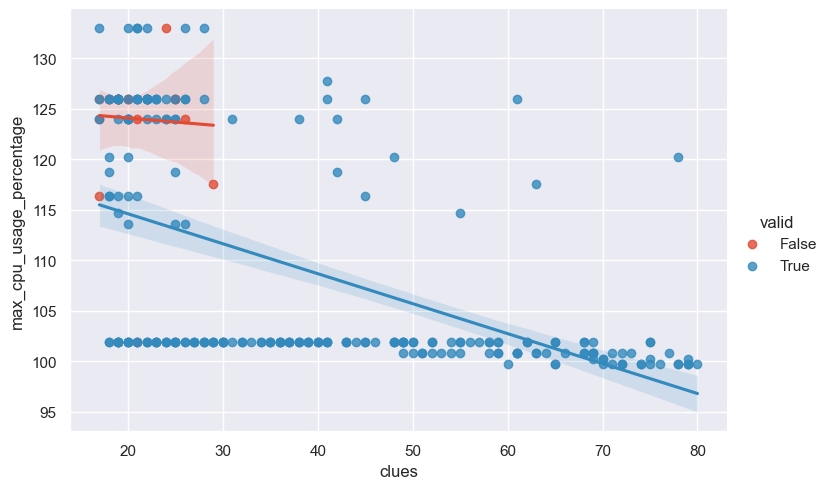

In [38]:
scatterplot_single(lsga_df, 'clues', 'max_cpu_usage_percentage', hue='valid')

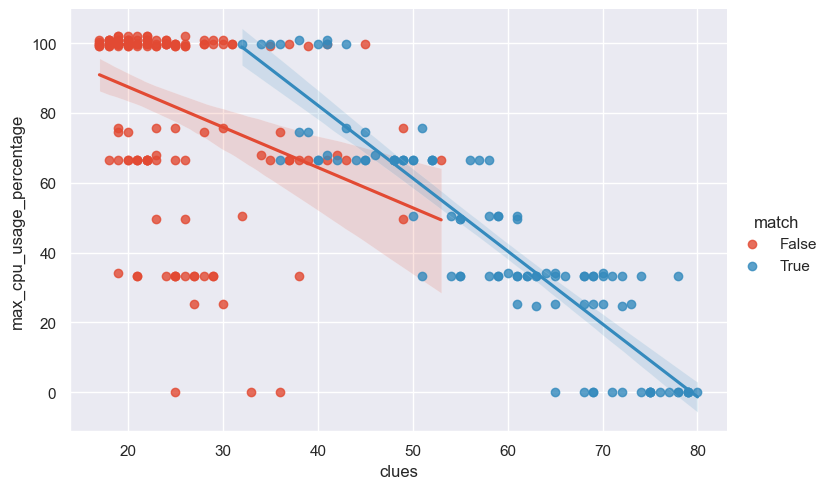

In [39]:
scatterplot_single(csp_df, 'clues', 'max_cpu_usage_percentage', hue='match')

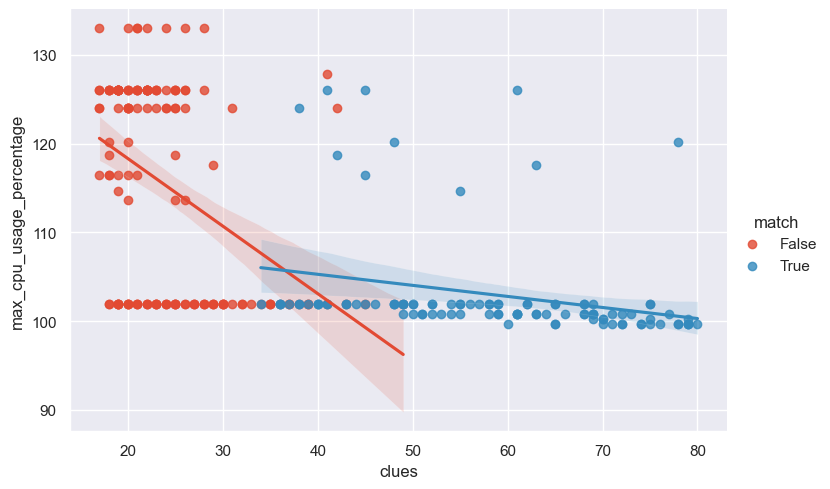

In [40]:
scatterplot_single(lsga_df, 'clues', 'max_cpu_usage_percentage', hue='match')

These plots are coherent with the previous analysis, the maximum amout of cpu usage is still comparable to the average use.

### Memory Usage

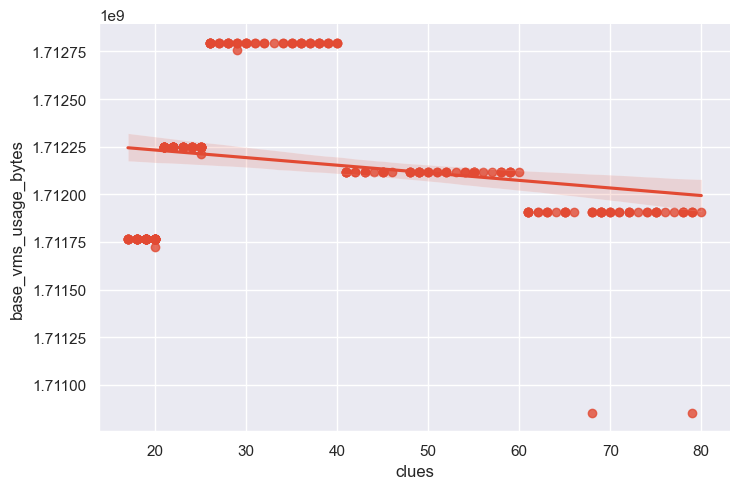

In [54]:
scatterplot_single(csp_df, 'clues', 'base_vms_usage_bytes')

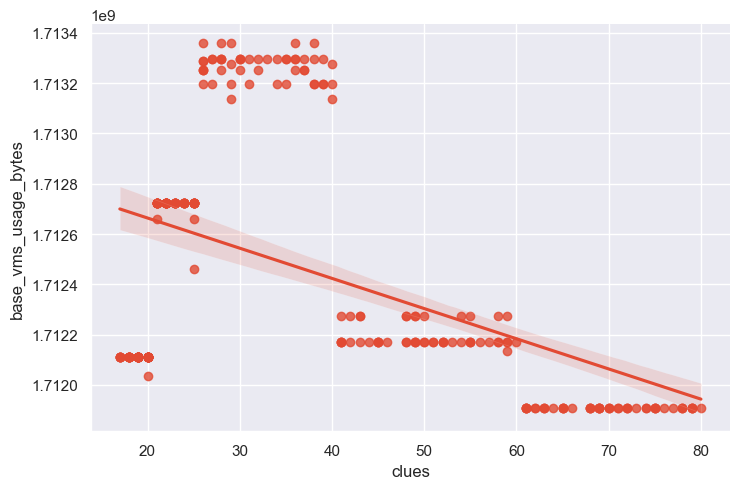

In [55]:
scatterplot_single(lsga_df, 'clues', 'base_vms_usage_bytes')

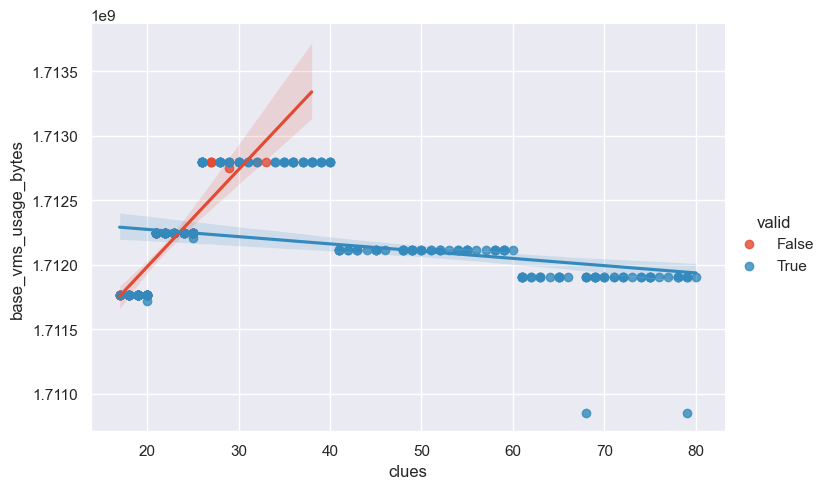

In [56]:
scatterplot_single(csp_df, 'clues', 'base_vms_usage_bytes', hue='valid')

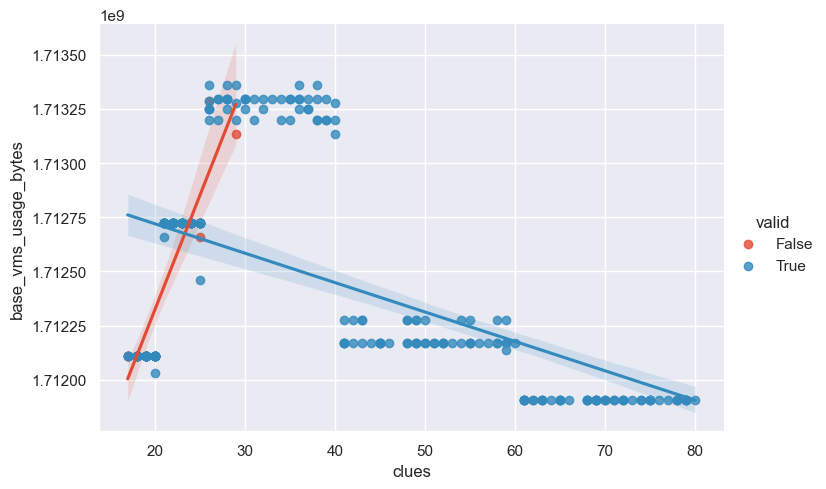

In [57]:
scatterplot_single(lsga_df, 'clues', 'base_vms_usage_bytes', hue='valid')

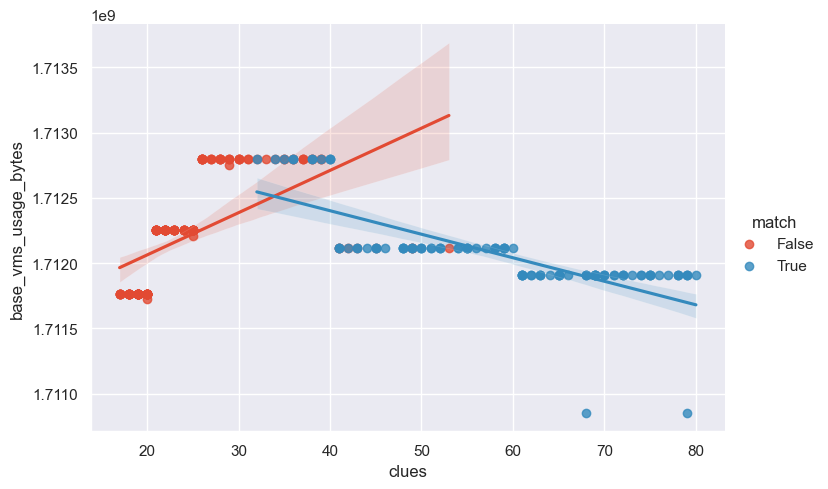

In [58]:
scatterplot_single(csp_df, 'clues', 'base_vms_usage_bytes', hue='match')

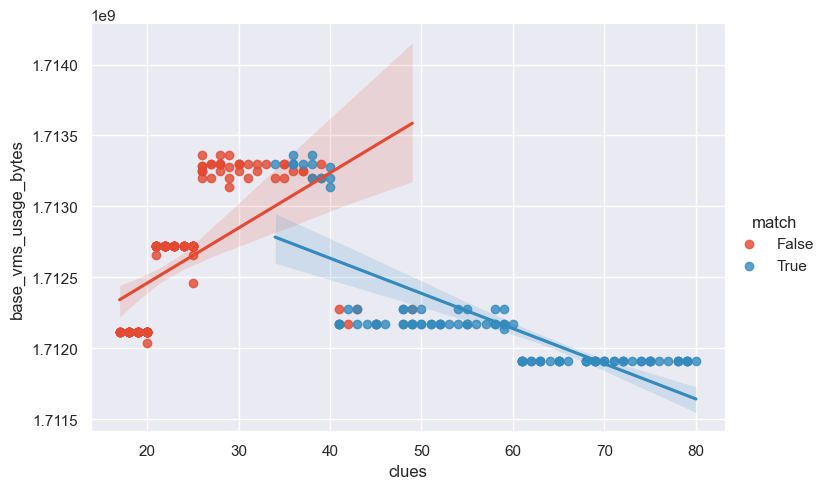

In [59]:
scatterplot_single(lsga_df, 'clues', 'base_vms_usage_bytes', hue='match')

Incredibly enough VMS does not seem to be a relevant issue for what concerns both algorithms, and seems to be proportionate in both algorithms.

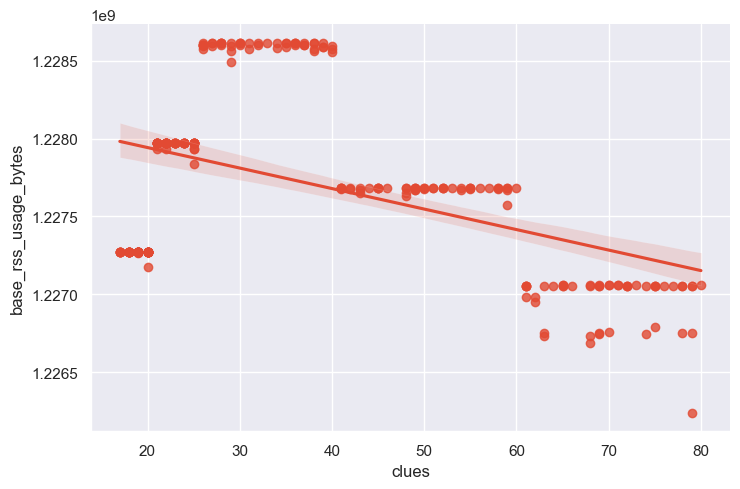

In [60]:
scatterplot_single(csp_df, 'clues', 'base_rss_usage_bytes')

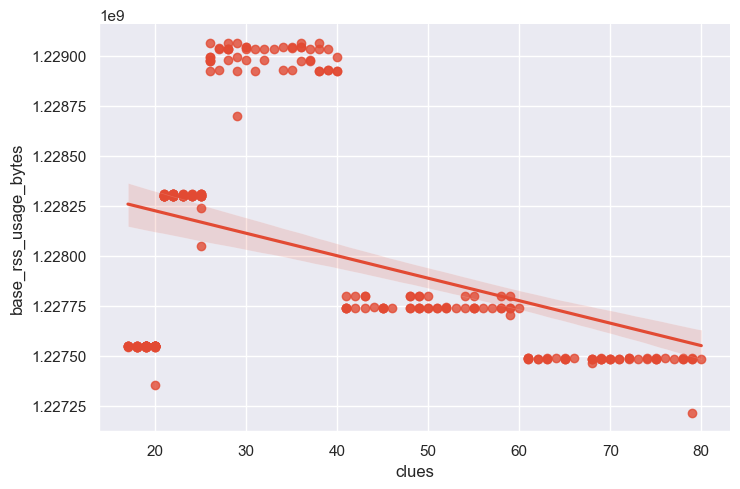

In [64]:
scatterplot_single(lsga_df, 'clues', 'base_rss_usage_bytes')

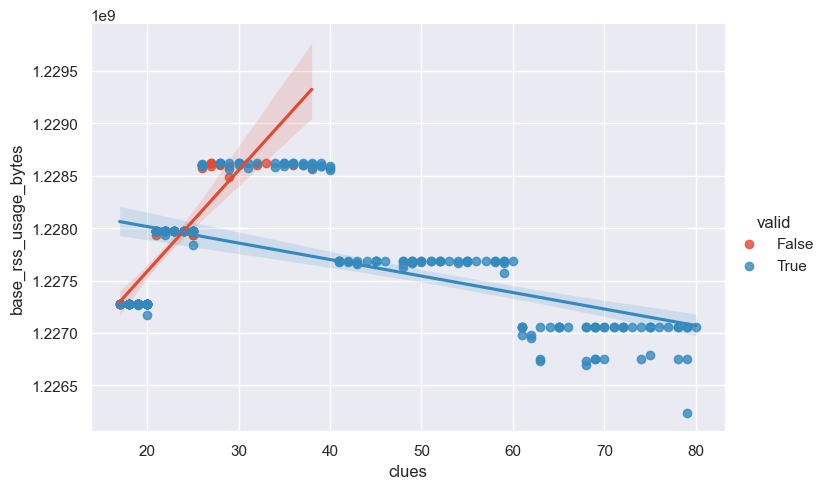

In [65]:
scatterplot_single(csp_df, 'clues', 'base_rss_usage_bytes', hue='valid')

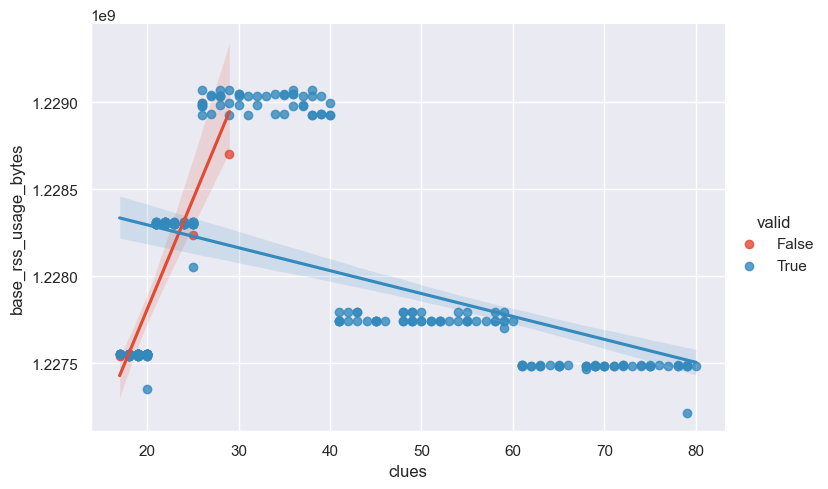

In [66]:
scatterplot_single(lsga_df, 'clues', 'base_rss_usage_bytes', hue='valid')

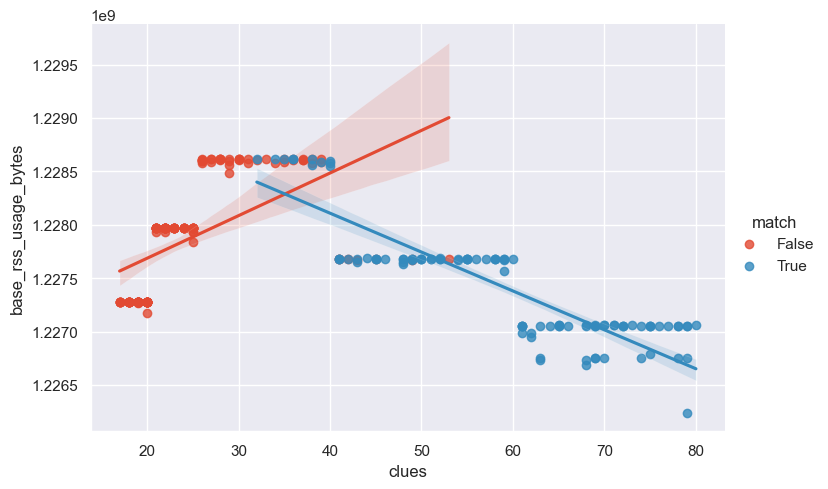

In [67]:
scatterplot_single(csp_df, 'clues', 'base_rss_usage_bytes', hue='match')

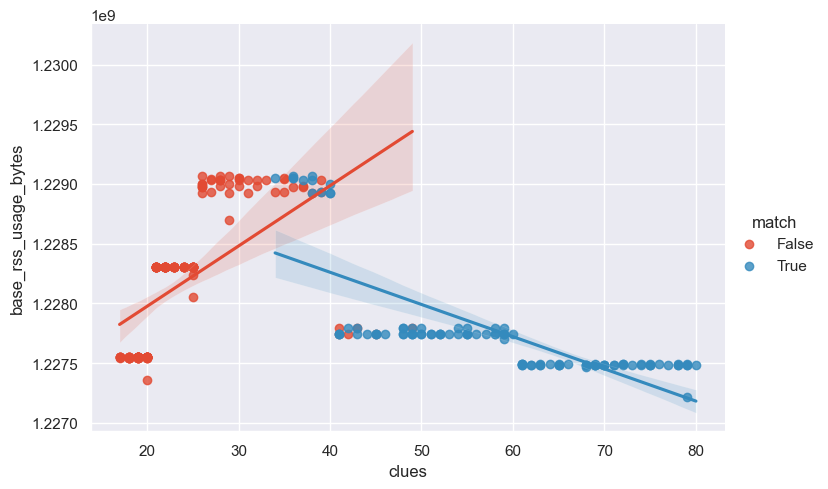

In [68]:
scatterplot_single(lsga_df, 'clues', 'base_rss_usage_bytes', hue='match')

Around the same base memory for RSS can be found in both algorithm benchmarks.